In [217]:
from python_speech_features import mfcc
import scipy.io.wavfile as wav
import numpy as np
from tempfile import TemporaryFile
import matplotlib.pyplot as plt
import os
import pickle
import random 
import operator
import math
import numpy as np
import os
import pandas as pd
import IPython.display as ipd
import librosa
import librosa.display
from scipy.fft import fft, ifft
from collections import Counter
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score, confusion_matrix, make_scorer,f1_score,log_loss
from sklearn.inspection import permutation_importance
from seaborn import pairplot
from sklearn.decomposition import PCA

import matplotlib

from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

from scipy.stats import norm, randint, uniform, poisson, expon

pd.options.display.max_columns = 1000
import shap

# make window wider
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# (see https://towardsdatascience.com/enabling-notifications-in-your-jupyter-notebooks-for-cell-completion-68d82b02bbc6#:~:text=Notify%20is%20a%20Jupyter%20Notebook,and%20Firefox%20(Version%3A%2053.0.)
%load_ext jupyternotify 

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [22]:
def read_data(features,timbre_features,filename,file_timbre):
    pdread = pd.read_csv(filename)
    dataframe = pd.DataFrame({})
    pdread_timbre = pd.read_csv(file_timbre)
    
    for l in range(len(features)):
        data_feature = np.array(pdread[pdread.index==l])
        data_feature[0][1:-1]
        dataframe[features[l]]=data_feature[0][1:-1]

    for l in range(len(timbre_features)):
        data_feature = np.array(pdread_timbre[pdread_timbre.index==l])
        dataframe[timbre_features[l]]=data_feature[0][1:-1]
        
    
    mads_data = pd.read_csv('syncopation_data.csv')
    new_data = pd.DataFrame({})
    for i in folders:
        new_data = pd.concat([new_data, mads_data[mads_data['genre']==i]])
        columns_new_data = new_data.columns[2:21]
    
    for l in columns_new_data:
        dataframe[columns_new_data] = new_data[columns_new_data]
    
    mads_data2 = pd.read_csv('rythmic_data.csv')
    new_data2 = pd.DataFrame({})
    for i in folders:
        new_data2 = pd.concat([new_data2, mads_data2[mads_data2['genre']==i]])
        columns_new_data2 = new_data2.columns[2:8]


    for l in columns_new_data2:
        dataframe[columns_new_data2] = new_data2[columns_new_data2]
    

    return(dataframe,columns_new_data,columns_new_data2)


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [3]:
# load all data
features = ['zerocrossing','spectralrolloff','chromagramstd','chromagrammean','fourier_std','fourier_mean','chroma_cens', 'class']
timbre_features = ['hardness','depth','brightness','roughness','warmth','sharpness','boominess','reverb']
folders = ['pop','jazz','blues','classical','hiphop','metal','rock','reggae','disco','country']

dataframe, columns_new_data,columns_new_data2 = read_data(features,timbre_features,"other_features.csv",'timbre_secure.csv')
dataframe['allEarly']=dataframe['overlap1Early']+dataframe['overlap2Early']+dataframe['overlap3Early']+dataframe['overlap4Early']+dataframe['overlap5Early']+dataframe['overlap6Early']
dataframe['allLate']=dataframe['overlap1Late']+dataframe['overlap2Late']+dataframe['overlap3Late']+dataframe['overlap4Late']+dataframe['overlap5Late']+dataframe['overlap6Late']
dataframe['synco'] = dataframe['allEarly']-dataframe['allLate']
dataframe.head(5)

,zerocrossing,spectralrolloff,chromagramstd,chromagrammean,fourier_std,fourier_mean,chroma_cens,class,hardness,depth,brightness,roughness,warmth,sharpness,boominess,reverb,overlap0,overlap1,overlap1Early,overlap1Late,overlap2,overlap2Early,overlap2Late,overlap3,overlap3Early,overlap3Late,overlap4,overlap4Early,overlap4Late,overlap5,overlap5Early,overlap5Late,overlap6,overlap6Early,overlap6Late,tempo,tempoHarmonic,tempoPercussive,onBeat,onBeatHarmonic,onBeatPercussive,allEarly,allLate,synco
0,490.0,7916.478436,0.286046,61.724392,155.002121,0.389286,0.301558,0.0,62.184903,64.482713,64.901826,54.344498,47.473584,58.247913,31.572225,1.0,1.753658,0.210424,0.013987,0.620453,0.040014,0.012410,0.176721,0.054571,0.025400,0.455789,0.047221,0.009912,0.108415,0.014026,0.005603,0.034720,0.011328,0.003119,0.020560,123.046875,123.046875,123.046875,0.219255,0.173677,0.175861,0.070431,1.416658,-1.346226
1,704.0,8049.560283,0.306736,98.570839,213.782852,0.413187,0.312815,0.0,63.719431,61.089713,68.271124,59.738090,45.438443,60.019366,32.193873,0.0,2.785280,0.394667,0.231321,0.139635,0.916249,0.278263,0.168726,1.532961,0.236100,0.073923,0.009115,0.002881,0.018700,0.430154,0.087305,0.016993,0.244307,0.056372,0.050570,67.999589,67.999589,67.999589,0.301049,0.216952,0.254102,0.892241,0.468547,0.423694
2,913.0,7392.282121,0.306183,71.167252,173.006790,0.417412,0.305931,0.0,61.194341,60.537756,64.919842,59.427448,46.784449,56.371713,34.493369,1.0,2.697888,0.132710,0.703458,0.026851,0.028507,0.455132,0.068784,0.018781,0.517178,0.008158,0.049385,0.087481,0.014999,0.036461,0.023254,0.011404,0.014722,0.022702,0.018540,161.499023,161.499023,161.499023,0.186501,0.139141,0.153761,1.809204,0.148736,1.660468
3,849.0,3639.036502,0.293715,44.226902,101.596466,0.407685,0.284466,0.0,59.058285,58.243250,63.018400,55.438606,48.175596,48.531268,31.120960,1.0,2.141774,0.234815,0.401124,0.182243,0.500865,0.377981,0.042896,0.631104,0.466492,0.018109,0.059323,0.058655,0.003395,0.137122,0.089858,0.013440,0.140773,0.112868,0.057044,63.024009,172.265625,63.024009,0.413590,0.136438,0.322781,1.506979,0.317127,1.189851
4,697.0,5958.993877,0.258193,89.199371,152.478058,0.384264,0.289209,0.0,62.573535,53.332775,65.535807,61.639147,44.527119,54.425945,27.943247,1.0,3.026272,0.276725,0.588319,0.049129,0.145096,0.293845,0.017441,0.138670,0.524937,0.071714,0.080301,0.139576,0.015173,0.038622,0.050418,0.016668,0.034647,0.039175,0.013946,135.999178,135.999178,135.999178,0.210587,0.190118,0.165812,1.636269,0.184070,1.452199


In [184]:
# choose a certain number of genres
dataframe_cut = pd.DataFrame({})
chosen_genres = [0,1,2,3,4,5,6,7,8,9]
#[3,5,8]

for i in chosen_genres:
    dataframe_cut = dataframe_cut.append(dataframe[dataframe['class']==i])

dataframe_cut['class_num'] = pd.factorize(dataframe_cut['class'])[0]

dataframe_cut.head(5)

plt.figure()
plt.plot([overlap0,overlap1,overlap2,overlap3,overlap4,overlap5,overlap6],'ko', linestyle = 'dashed', label='on beat')
plt.plot([overlap0,overlap1Early,overlap2Early,overlap3Early,overlap4Early,overlap5Early,overlap6Early],'go', linestyle = 'dashed', label='Early')
plt.plot([overlap0,overlap1Late,overlap2Late,overlap3Late,overlap4Late,overlap5Late,overlap6Late],'ro', linestyle = 'dashed', label='late')
plt.xlabel('Beat #')

,zerocrossing,spectralrolloff,chromagramstd,chromagrammean,fourier_std,fourier_mean,chroma_cens,class,hardness,depth,brightness,roughness,warmth,sharpness,boominess,reverb,overlap0,overlap1,overlap1Early,overlap1Late,overlap2,overlap2Early,overlap2Late,overlap3,overlap3Early,overlap3Late,overlap4,overlap4Early,overlap4Late,overlap5,overlap5Early,overlap5Late,overlap6,overlap6Early,overlap6Late,tempo,tempoHarmonic,tempoPercussive,onBeat,onBeatHarmonic,onBeatPercussive,allEarly,allLate,synco,class_num
0,490.0,7916.478436,0.286046,61.724392,155.002121,0.389286,0.301558,0.0,62.184903,64.482713,64.901826,54.344498,47.473584,58.247913,31.572225,1.0,1.753658,0.210424,0.013987,0.620453,0.040014,0.012410,0.176721,0.054571,0.025400,0.455789,0.047221,0.009912,0.108415,0.014026,0.005603,0.034720,0.011328,0.003119,0.020560,123.046875,123.046875,123.046875,0.219255,0.173677,0.175861,0.070431,1.416658,-1.346226,0
1,704.0,8049.560283,0.306736,98.570839,213.782852,0.413187,0.312815,0.0,63.719431,61.089713,68.271124,59.738090,45.438443,60.019366,32.193873,0.0,2.785280,0.394667,0.231321,0.139635,0.916249,0.278263,0.168726,1.532961,0.236100,0.073923,0.009115,0.002881,0.018700,0.430154,0.087305,0.016993,0.244307,0.056372,0.050570,67.999589,67.999589,67.999589,0.301049,0.216952,0.254102,0.892241,0.468547,0.423694,0
2,913.0,7392.282121,0.306183,71.167252,173.006790,0.417412,0.305931,0.0,61.194341,60.537756,64.919842,59.427448,46.784449,56.371713,34.493369,1.0,2.697888,0.132710,0.703458,0.026851,0.028507,0.455132,0.068784,0.018781,0.517178,0.008158,0.049385,0.087481,0.014999,0.036461,0.023254,0.011404,0.014722,0.022702,0.018540,161.499023,161.499023,161.499023,0.186501,0.139141,0.153761,1.809204,0.148736,1.660468,0
3,849.0,3639.036502,0.293715,44.226902,101.596466,0.407685,0.284466,0.0,59.058285,58.243250,63.018400,55.438606,48.175596,48.531268,31.120960,1.0,2.141774,0.234815,0.401124,0.182243,0.500865,0.377981,0.042896,0.631104,0.466492,0.018109,0.059323,0.058655,0.003395,0.137122,0.089858,0.013440,0.140773,0.112868,0.057044,63.024009,172.265625,63.024009,0.413590,0.136438,0.322781,1.506979,0.317127,1.189851,0
4,697.0,5958.993877,0.258193,89.199371,152.478058,0.384264,0.289209,0.0,62.573535,53.332775,65.535807,61.639147,44.527119,54.425945,27.943247,1.0,3.026272,0.276725,0.588319,0.049129,0.145096,0.293845,0.017441,0.138670,0.524937,0.071714,0.080301,0.139576,0.015173,0.038622,0.050418,0.016668,0.034647,0.039175,0.013946,135.999178,135.999178,135.999178,0.210587,0.190118,0.165812,1.636269,0.184070,1.452199,0


In [236]:
# choose which variables to look at
df_1=[]
# train_features = np.concatenate([['zerocrossing','spectralrolloff','chromagramstd','chromagrammean','fourier_std',
#                   'fourier_mean','chroma_cens','hardness','depth','brightness','roughness','warmth',
#                   'sharpness','boominess','reverb'],
#                                  ['synco', 'allLate', 'allEarly'],
#                                  columns_new_data, 
#                                  columns_new_data2])


train_features = ['zerocrossing','spectralrolloff','chromagramstd','chromagrammean','fourier_std',
                  'fourier_mean','chroma_cens','hardness','depth','brightness','roughness','warmth',
                  'sharpness','boominess']

# top15_features = ['fourier_mean',
#                  'overlap0',
#                  'spectralrolloff',
#                  'chroma_cens',
#                  'fourier_std',
#                  'roughness',
#                  'hardness',
#                  'onBeatHarmonic',
#                  'chromagrammean',
#                  'chromagramstd',
#                  'boominess',
#                  'depth',
#                  'onBeat',
#                  'warmth',
#                  'sharpness']

top15_features_OLD = ['fourier_mean',
                 'overlap0',
                 'chroma_cens',
                 'spectralrolloff',
                 'roughness',
                 'fourier_std',
                 'onBeatHarmonic',
                 'chromagrammean',
                 'hardness',
                 'depth',
                 'chromagramstd',
                 'boominess',
                 'warmth',
                 'onBeatPercussive',
                 'overlap5']

top10_features_old = ['overlap0',
                 'fourier_mean',
                 'roughness',
                 'spectralrolloff',
                 'chroma_cens',
                 'fourier_std',
                 'onBeat',
                 'onBeatHarmonic',
                 'chromagramstd',
                 'chromagrammean']

top15_features = ['overlap0',
                 'fourier_mean',
                 'roughness',
                 'chroma_cens',
                 'spectralrolloff',
                 'fourier_std',
                 'hardness',
                 'warmth',
                 'chromagrammean',
                 'onBeatHarmonic',
                 'boominess',
                 'sharpness',
                 'onBeatPercussive',
                 'tempoHarmonic',
                 'onBeat']
top10_features = ['overlap0',
                 'fourier_mean',
                 'chroma_cens',
                 'roughness',
                 'spectralrolloff',
                 'fourier_std',
                 'onBeatHarmonic',
                 'boominess',
                 'warmth',
                 'chromagrammean']

top7_features = ['overlap0',
                 'fourier_mean',
                 'spectralrolloff',
                 'roughness',
                 'chroma_cens',
                 'fourier_std',
                 'warmth']

moreThan10pctFeats = ['fourier_mean', 'overlap0', 'chroma_cens', 'roughness',
       'spectralrolloff', 'fourier_std', 'chromagrammean', 'hardness',
       'boominess', 'onBeatHarmonic', 'overlap6', 'overlap5', 'warmth',
       'sharpness', 'chromagramstd', 'onBeatPercussive', 'overlap6Late',
       'overlap2Early', 'onBeat', 'brightness', 'overlap3Late',
       'tempoHarmonic', 'overlap5Early', 'overlap4Late', 'depth',
       'overlap4', 'overlap5Late', 'tempo', 'overlap2', 'overlap3Early',
       'tempoPercussive', 'overlap2Late', 'overlap1Early',
       'overlap4Early', 'reverb', 'overlap1', 'overlap6Early',
       'zerocrossing', 'synco', 'overlap3', 'overlap1Late']


top10SHAP = ['fourier_mean', 'overlap0','roughness','spectralrolloff','chroma_cens','chromagrammean','fourier_std','overlap5','hardness']

top12SHAP = ['fourier_mean', 'overlap0','roughness','spectralrolloff','chroma_cens','chromagrammean','fourier_std','overlap5','hardness','boominess', 'overlap6','onBeatHarmonic']
# train_features = top12SHAP


df_1=dataframe_cut[train_features]

#Scaling using the Standard Scaler
sc_1=StandardScaler()
# sc_1 = RobustScaler()
sc_1.fit(df_1)
X_1=pd.DataFrame(sc_1.fit_transform(df_1))#, columns=train_features)



pca = PCA(n_components = 6)
pca_features = pca.fit_transform(X_1)

Y_1=dataframe_cut['class_num']
X_1.head(5)
len(train_features)
Y_1.head(5)
pca_features = pd.DataFrame(pca_features,columns=['PC1', 'PC2', 'PC3','PC4','PC5','PC6'])
X_1 = pca_features

In [245]:
# X = pd.DataFrame(StandardScaler().fit_transform(X), columns = Xold.columns)
# train_features_PP = ['onBeatHarmonic','onBeatPercussive']

# train_features_PP = ['onBeatHarmonic','onBeatPercussive','allEarly','allLate']

# train_features_PP = columns_new_data2

train_features_PP = ['zerocrossing','spectralrolloff','chromagramstd','chromagrammean','fourier_std',
                  'fourier_mean','chroma_cens','hardness','depth','brightness','roughness','warmth',
                  'sharpness','boominess']

# train_features_PP = ['overlap0','overlap1','overlap2','overlap3','overlap4','overlap5','overlap6']
colNames = dict(zip(range(len(train_features_PP)),train_features_PP))

sc_1.fit(df_1)
X_1=pd.DataFrame(sc_1.fit_transform(dataframe_cut[train_features_PP]))#, columns=train_features)
Xpp=X_1
Xpp.rename(columns=colNames, inplace=True)
ypp=Y_1
yppdf = ypp.to_frame()
# print(ypp)
Xpp.head(5)
yppdf.head(5)
XYpp = pd.concat([Xpp,yppdf],axis=1)
pd.concat([pca_features,yppdf],axis=1).head(5)
# XYpp.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6,class_num
0,-1.201805,-2.360011,-0.965213,0.410435,-0.767042,-0.990256,0
1,-2.760974,-2.660110,-2.341426,0.447262,-0.227014,-0.597886,0
2,-1.612653,-2.317370,-1.085247,0.651673,-0.416065,-0.117436,0
3,0.457565,-0.596449,0.853869,0.522494,0.473278,0.041036,0
4,-1.890963,-0.400066,-0.917062,-0.286146,0.902194,-0.503710,0


<Figure size 1440x1440 with 0 Axes>

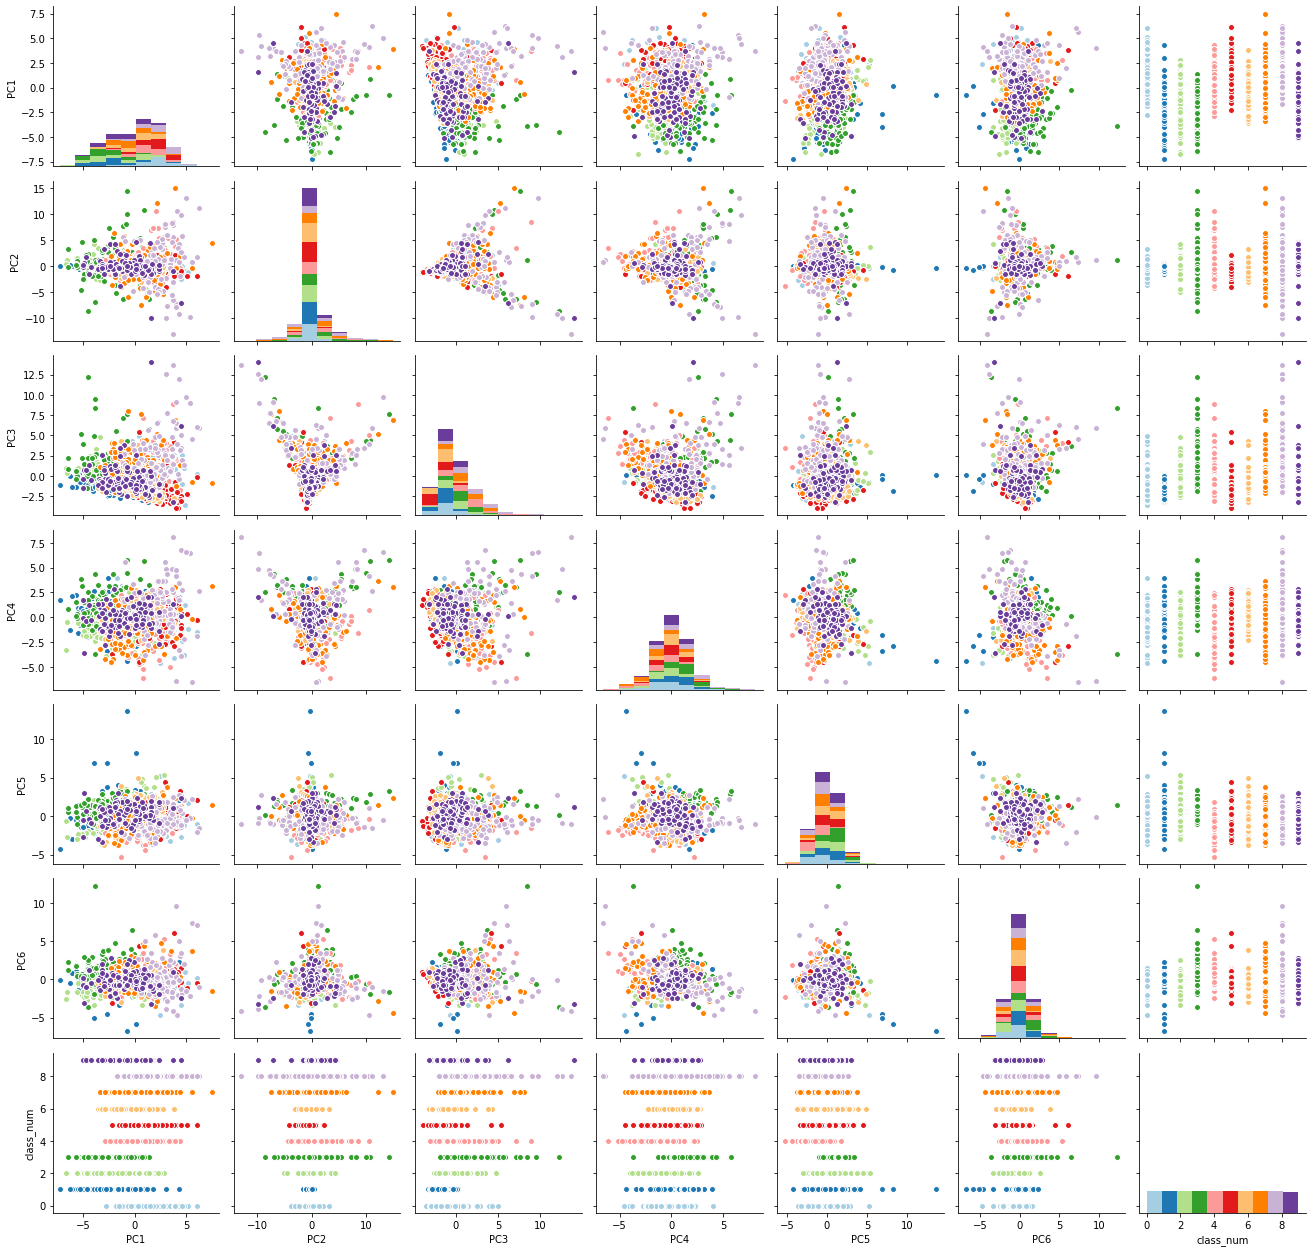

In [232]:
fpp = plt.figure('pairplot',figsize=(20,20))
plt.clf()
# g=pairplot(XYpp,hue='class_num',palette = "Paired")
g=pairplot(pd.concat([pca_features,yppdf],axis=1),hue='class_num',palette = "Paired")

g._legend.remove()
plt.tight_layout()
plt.savefig('plotsAfterGridsearch/PairPlotPCA6.png',dpi=200)

In [180]:
palette = "Paired"

<Figure size 432x288 with 0 Axes>

In [246]:
# set up LGBM classifier
params={}
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='multiclass' #Multi-class target feature
params['metric']='multi_logloss' #metric for multi-class
# params['metric']='f1' #metric for multi-class
# params['max_depth']=10 # sofus param value
params['max_depth'] = 6 # Mads param value found by grid serach
params['num_class']=10
# params['num_leaves']=14 # Sofus param value
params['num_leaves']=9 # Mads param value found by grid search
params['force_col_wise']=True
params['verbose'] = -2
# params['learning_rate']=0.1 # Sofus param value
# params['learning_rate']= 0.002
params['learning_rate']= 0.0008137059759269703 # found by Grid Search
params['n_estimators']=30000
epochs = 500
#len(os.listdir()) #no.of unique values in the target class not inclusive of the end value
#training the model
score_array=[]

# optimal after grid search 'learning_rate': 0.0008137059759269703, 'max_depth': 6, 'num_leaves': 9

evals_result={}

In [247]:
# run LGBM classifier
test = False
Nparams=100

# testsize = 0.2

NstopRound = 1000


if test==True:
    score_array=[]
    runNo = []
    for param in range(Nparams):
        print('running test {:d} of {:d}'.format(param+1, Nparams))
        #params['max_depth']=param+1
        X_train,X_test,y_train,y_test=train_test_split(X_1,Y_1,test_size=testsize,random_state=param)
        d_train=lgb.Dataset(X_train, label=y_train)

        clf=lgb.train(params,d_train,param*100+1)

        y_pred_1=clf.predict(X_test)

        y_pred_m = [np.argmax(line) for line in y_pred_1]

        score = precision_score(y_pred_m,y_test,average=None).mean()
        score_array.append(score)
        runNo.append(param)
    plt.figure('test precision scores')
    plt.plot(np.arange(0,Nparams,1),score_array)
    plt.ylim([0,1])
    plt.grid()
else:
    X_train,X_test,y_train,y_test=train_test_split(X_1,Y_1,test_size=0.3,random_state=42)
    X_val, X_test, y_val, y_test=train_test_split(X_test, y_test, test_size=0.66,random_state=42)
    d_train=lgb.Dataset(X_train, label=y_train)
    d_val = lgb.Dataset(X_val, label=y_val)
    
    clf = lgb.LGBMClassifier()
    clf.set_params(**params)
    clf.fit(X_train, y_train, eval_set =[(X_val,y_val)],early_stopping_rounds = NstopRound)
#     clf=lgb.train(params,d_train ,epochs)

    y_pred_1=clf.predict(X_test)

    y_pred_m = [np.argmax(line) for line in y_pred_1]

#     score = precision_score(y_pred_m,y_test,average=None).mean()
    score = precision_score(y_pred_1,y_test,average=None).mean()
    

print(score)
# print(np.array(y_test)-np.array(y_pred_m))
print(np.array(y_test)-np.array(y_pred_1))
print(y_pred_1)

%notify -m "First fitting done!"

[1]	valid_0's multi_logloss: 2.3022
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's multi_logloss: 2.29976
[3]	valid_0's multi_logloss: 2.29733
[4]	valid_0's multi_logloss: 2.29492
[5]	valid_0's multi_logloss: 2.29252
[6]	valid_0's multi_logloss: 2.29015
[7]	valid_0's multi_logloss: 2.28783
[8]	valid_0's multi_logloss: 2.28549
[9]	valid_0's multi_logloss: 2.28319
[10]	valid_0's multi_logloss: 2.28087
[11]	valid_0's multi_logloss: 2.27853
[12]	valid_0's multi_logloss: 2.27629
[13]	valid_0's multi_logloss: 2.27398
[14]	valid_0's multi_logloss: 2.27173
[15]	valid_0's multi_logloss: 2.26942
[16]	valid_0's multi_logloss: 2.26719
[17]	valid_0's multi_logloss: 2.26491
[18]	valid_0's multi_logloss: 2.26268
[19]	valid_0's multi_logloss: 2.26048
[20]	valid_0's multi_logloss: 2.25822
[21]	valid_0's multi_logloss: 2.25602
[22]	valid_0's multi_logloss: 2.2538
[23]	valid_0's multi_logloss: 2.2516
[24]	valid_0's multi_logloss: 2.24941
[25]	valid_0's multi_logloss: 2.24718

[226]	valid_0's multi_logloss: 1.93144
[227]	valid_0's multi_logloss: 1.93031
[228]	valid_0's multi_logloss: 1.92916
[229]	valid_0's multi_logloss: 1.92803
[230]	valid_0's multi_logloss: 1.92694
[231]	valid_0's multi_logloss: 1.92579
[232]	valid_0's multi_logloss: 1.92466
[233]	valid_0's multi_logloss: 1.92359
[234]	valid_0's multi_logloss: 1.92246
[235]	valid_0's multi_logloss: 1.92134
[236]	valid_0's multi_logloss: 1.92023
[237]	valid_0's multi_logloss: 1.91912
[238]	valid_0's multi_logloss: 1.91806
[239]	valid_0's multi_logloss: 1.91693
[240]	valid_0's multi_logloss: 1.91583
[241]	valid_0's multi_logloss: 1.91472
[242]	valid_0's multi_logloss: 1.91365
[243]	valid_0's multi_logloss: 1.91253
[244]	valid_0's multi_logloss: 1.91142
[245]	valid_0's multi_logloss: 1.91036
[246]	valid_0's multi_logloss: 1.90926
[247]	valid_0's multi_logloss: 1.90814
[248]	valid_0's multi_logloss: 1.90709
[249]	valid_0's multi_logloss: 1.90597
[250]	valid_0's multi_logloss: 1.90488
[251]	valid_0's multi_log

[440]	valid_0's multi_logloss: 1.73092
[441]	valid_0's multi_logloss: 1.73023
[442]	valid_0's multi_logloss: 1.72951
[443]	valid_0's multi_logloss: 1.72873
[444]	valid_0's multi_logloss: 1.72798
[445]	valid_0's multi_logloss: 1.72723
[446]	valid_0's multi_logloss: 1.72646
[447]	valid_0's multi_logloss: 1.72579
[448]	valid_0's multi_logloss: 1.72502
[449]	valid_0's multi_logloss: 1.72432
[450]	valid_0's multi_logloss: 1.72356
[451]	valid_0's multi_logloss: 1.72282
[452]	valid_0's multi_logloss: 1.72208
[453]	valid_0's multi_logloss: 1.7214
[454]	valid_0's multi_logloss: 1.72058
[455]	valid_0's multi_logloss: 1.71997
[456]	valid_0's multi_logloss: 1.71926
[457]	valid_0's multi_logloss: 1.71861
[458]	valid_0's multi_logloss: 1.71784
[459]	valid_0's multi_logloss: 1.71709
[460]	valid_0's multi_logloss: 1.71638
[461]	valid_0's multi_logloss: 1.71575
[462]	valid_0's multi_logloss: 1.71497
[463]	valid_0's multi_logloss: 1.7143
[464]	valid_0's multi_logloss: 1.71356
[465]	valid_0's multi_loglo

[651]	valid_0's multi_logloss: 1.59953
[652]	valid_0's multi_logloss: 1.599
[653]	valid_0's multi_logloss: 1.59846
[654]	valid_0's multi_logloss: 1.59785
[655]	valid_0's multi_logloss: 1.59733
[656]	valid_0's multi_logloss: 1.59677
[657]	valid_0's multi_logloss: 1.59618
[658]	valid_0's multi_logloss: 1.59566
[659]	valid_0's multi_logloss: 1.59514
[660]	valid_0's multi_logloss: 1.59459
[661]	valid_0's multi_logloss: 1.59402
[662]	valid_0's multi_logloss: 1.59351
[663]	valid_0's multi_logloss: 1.59299
[664]	valid_0's multi_logloss: 1.59242
[665]	valid_0's multi_logloss: 1.59186
[666]	valid_0's multi_logloss: 1.59131
[667]	valid_0's multi_logloss: 1.59077
[668]	valid_0's multi_logloss: 1.59022
[669]	valid_0's multi_logloss: 1.5897
[670]	valid_0's multi_logloss: 1.58912
[671]	valid_0's multi_logloss: 1.58858
[672]	valid_0's multi_logloss: 1.58801
[673]	valid_0's multi_logloss: 1.58747
[674]	valid_0's multi_logloss: 1.58696
[675]	valid_0's multi_logloss: 1.5864
[676]	valid_0's multi_logloss

[875]	valid_0's multi_logloss: 1.49712
[876]	valid_0's multi_logloss: 1.49678
[877]	valid_0's multi_logloss: 1.49644
[878]	valid_0's multi_logloss: 1.49611
[879]	valid_0's multi_logloss: 1.49575
[880]	valid_0's multi_logloss: 1.49544
[881]	valid_0's multi_logloss: 1.49509
[882]	valid_0's multi_logloss: 1.49475
[883]	valid_0's multi_logloss: 1.49444
[884]	valid_0's multi_logloss: 1.49413
[885]	valid_0's multi_logloss: 1.49371
[886]	valid_0's multi_logloss: 1.49335
[887]	valid_0's multi_logloss: 1.49298
[888]	valid_0's multi_logloss: 1.49266
[889]	valid_0's multi_logloss: 1.49235
[890]	valid_0's multi_logloss: 1.49198
[891]	valid_0's multi_logloss: 1.49162
[892]	valid_0's multi_logloss: 1.49128
[893]	valid_0's multi_logloss: 1.49093
[894]	valid_0's multi_logloss: 1.4906
[895]	valid_0's multi_logloss: 1.49027
[896]	valid_0's multi_logloss: 1.48985
[897]	valid_0's multi_logloss: 1.48951
[898]	valid_0's multi_logloss: 1.48913
[899]	valid_0's multi_logloss: 1.48882
[900]	valid_0's multi_logl

[1086]	valid_0's multi_logloss: 1.43231
[1087]	valid_0's multi_logloss: 1.43202
[1088]	valid_0's multi_logloss: 1.43178
[1089]	valid_0's multi_logloss: 1.43158
[1090]	valid_0's multi_logloss: 1.43132
[1091]	valid_0's multi_logloss: 1.43109
[1092]	valid_0's multi_logloss: 1.4308
[1093]	valid_0's multi_logloss: 1.43055
[1094]	valid_0's multi_logloss: 1.43028
[1095]	valid_0's multi_logloss: 1.43005
[1096]	valid_0's multi_logloss: 1.42981
[1097]	valid_0's multi_logloss: 1.42959
[1098]	valid_0's multi_logloss: 1.42932
[1099]	valid_0's multi_logloss: 1.42908
[1100]	valid_0's multi_logloss: 1.42889
[1101]	valid_0's multi_logloss: 1.42862
[1102]	valid_0's multi_logloss: 1.42837
[1103]	valid_0's multi_logloss: 1.42811
[1104]	valid_0's multi_logloss: 1.42791
[1105]	valid_0's multi_logloss: 1.42762
[1106]	valid_0's multi_logloss: 1.42734
[1107]	valid_0's multi_logloss: 1.42716
[1108]	valid_0's multi_logloss: 1.42686
[1109]	valid_0's multi_logloss: 1.42669
[1110]	valid_0's multi_logloss: 1.42643
[

[1294]	valid_0's multi_logloss: 1.38503
[1295]	valid_0's multi_logloss: 1.38493
[1296]	valid_0's multi_logloss: 1.38467
[1297]	valid_0's multi_logloss: 1.3845
[1298]	valid_0's multi_logloss: 1.38434
[1299]	valid_0's multi_logloss: 1.38412
[1300]	valid_0's multi_logloss: 1.38393
[1301]	valid_0's multi_logloss: 1.3837
[1302]	valid_0's multi_logloss: 1.38351
[1303]	valid_0's multi_logloss: 1.38329
[1304]	valid_0's multi_logloss: 1.38315
[1305]	valid_0's multi_logloss: 1.38294
[1306]	valid_0's multi_logloss: 1.38278
[1307]	valid_0's multi_logloss: 1.3826
[1308]	valid_0's multi_logloss: 1.3824
[1309]	valid_0's multi_logloss: 1.3822
[1310]	valid_0's multi_logloss: 1.38201
[1311]	valid_0's multi_logloss: 1.38181
[1312]	valid_0's multi_logloss: 1.3816
[1313]	valid_0's multi_logloss: 1.38143
[1314]	valid_0's multi_logloss: 1.38119
[1315]	valid_0's multi_logloss: 1.38102
[1316]	valid_0's multi_logloss: 1.38079
[1317]	valid_0's multi_logloss: 1.38057
[1318]	valid_0's multi_logloss: 1.38034
[1319]

[1499]	valid_0's multi_logloss: 1.34472
[1500]	valid_0's multi_logloss: 1.34456
[1501]	valid_0's multi_logloss: 1.34442
[1502]	valid_0's multi_logloss: 1.34424
[1503]	valid_0's multi_logloss: 1.34416
[1504]	valid_0's multi_logloss: 1.34396
[1505]	valid_0's multi_logloss: 1.3438
[1506]	valid_0's multi_logloss: 1.34366
[1507]	valid_0's multi_logloss: 1.34343
[1508]	valid_0's multi_logloss: 1.34331
[1509]	valid_0's multi_logloss: 1.34314
[1510]	valid_0's multi_logloss: 1.34301
[1511]	valid_0's multi_logloss: 1.34281
[1512]	valid_0's multi_logloss: 1.34268
[1513]	valid_0's multi_logloss: 1.3425
[1514]	valid_0's multi_logloss: 1.34237
[1515]	valid_0's multi_logloss: 1.3422
[1516]	valid_0's multi_logloss: 1.342
[1517]	valid_0's multi_logloss: 1.34187
[1518]	valid_0's multi_logloss: 1.34172
[1519]	valid_0's multi_logloss: 1.34154
[1520]	valid_0's multi_logloss: 1.3414
[1521]	valid_0's multi_logloss: 1.34129
[1522]	valid_0's multi_logloss: 1.34111
[1523]	valid_0's multi_logloss: 1.34092
[1524]

[1714]	valid_0's multi_logloss: 1.31537
[1715]	valid_0's multi_logloss: 1.31526
[1716]	valid_0's multi_logloss: 1.31516
[1717]	valid_0's multi_logloss: 1.31508
[1718]	valid_0's multi_logloss: 1.31499
[1719]	valid_0's multi_logloss: 1.31486
[1720]	valid_0's multi_logloss: 1.31479
[1721]	valid_0's multi_logloss: 1.31466
[1722]	valid_0's multi_logloss: 1.31454
[1723]	valid_0's multi_logloss: 1.31445
[1724]	valid_0's multi_logloss: 1.31434
[1725]	valid_0's multi_logloss: 1.31424
[1726]	valid_0's multi_logloss: 1.31413
[1727]	valid_0's multi_logloss: 1.31403
[1728]	valid_0's multi_logloss: 1.3139
[1729]	valid_0's multi_logloss: 1.31378
[1730]	valid_0's multi_logloss: 1.31368
[1731]	valid_0's multi_logloss: 1.31359
[1732]	valid_0's multi_logloss: 1.31348
[1733]	valid_0's multi_logloss: 1.31336
[1734]	valid_0's multi_logloss: 1.31326
[1735]	valid_0's multi_logloss: 1.31312
[1736]	valid_0's multi_logloss: 1.31304
[1737]	valid_0's multi_logloss: 1.31293
[1738]	valid_0's multi_logloss: 1.31284
[

[1929]	valid_0's multi_logloss: 1.29606
[1930]	valid_0's multi_logloss: 1.29598
[1931]	valid_0's multi_logloss: 1.29594
[1932]	valid_0's multi_logloss: 1.2959
[1933]	valid_0's multi_logloss: 1.29582
[1934]	valid_0's multi_logloss: 1.29581
[1935]	valid_0's multi_logloss: 1.29575
[1936]	valid_0's multi_logloss: 1.29566
[1937]	valid_0's multi_logloss: 1.29557
[1938]	valid_0's multi_logloss: 1.29553
[1939]	valid_0's multi_logloss: 1.29545
[1940]	valid_0's multi_logloss: 1.29536
[1941]	valid_0's multi_logloss: 1.29532
[1942]	valid_0's multi_logloss: 1.29531
[1943]	valid_0's multi_logloss: 1.29523
[1944]	valid_0's multi_logloss: 1.29518
[1945]	valid_0's multi_logloss: 1.29511
[1946]	valid_0's multi_logloss: 1.29499
[1947]	valid_0's multi_logloss: 1.29493
[1948]	valid_0's multi_logloss: 1.29494
[1949]	valid_0's multi_logloss: 1.29486
[1950]	valid_0's multi_logloss: 1.29479
[1951]	valid_0's multi_logloss: 1.2947
[1952]	valid_0's multi_logloss: 1.29468
[1953]	valid_0's multi_logloss: 1.29461
[1

[2141]	valid_0's multi_logloss: 1.28351
[2142]	valid_0's multi_logloss: 1.28346
[2143]	valid_0's multi_logloss: 1.28335
[2144]	valid_0's multi_logloss: 1.28333
[2145]	valid_0's multi_logloss: 1.28329
[2146]	valid_0's multi_logloss: 1.28314
[2147]	valid_0's multi_logloss: 1.28309
[2148]	valid_0's multi_logloss: 1.28299
[2149]	valid_0's multi_logloss: 1.28295
[2150]	valid_0's multi_logloss: 1.28285
[2151]	valid_0's multi_logloss: 1.28281
[2152]	valid_0's multi_logloss: 1.28275
[2153]	valid_0's multi_logloss: 1.2827
[2154]	valid_0's multi_logloss: 1.28266
[2155]	valid_0's multi_logloss: 1.28261
[2156]	valid_0's multi_logloss: 1.28248
[2157]	valid_0's multi_logloss: 1.28239
[2158]	valid_0's multi_logloss: 1.28233
[2159]	valid_0's multi_logloss: 1.28224
[2160]	valid_0's multi_logloss: 1.28227
[2161]	valid_0's multi_logloss: 1.28221
[2162]	valid_0's multi_logloss: 1.28212
[2163]	valid_0's multi_logloss: 1.28205
[2164]	valid_0's multi_logloss: 1.28204
[2165]	valid_0's multi_logloss: 1.28199
[

[2354]	valid_0's multi_logloss: 1.27305
[2355]	valid_0's multi_logloss: 1.273
[2356]	valid_0's multi_logloss: 1.27294
[2357]	valid_0's multi_logloss: 1.27287
[2358]	valid_0's multi_logloss: 1.27287
[2359]	valid_0's multi_logloss: 1.27277
[2360]	valid_0's multi_logloss: 1.2727
[2361]	valid_0's multi_logloss: 1.27267
[2362]	valid_0's multi_logloss: 1.27262
[2363]	valid_0's multi_logloss: 1.27249
[2364]	valid_0's multi_logloss: 1.27246
[2365]	valid_0's multi_logloss: 1.27245
[2366]	valid_0's multi_logloss: 1.27234
[2367]	valid_0's multi_logloss: 1.27229
[2368]	valid_0's multi_logloss: 1.27222
[2369]	valid_0's multi_logloss: 1.27212
[2370]	valid_0's multi_logloss: 1.2721
[2371]	valid_0's multi_logloss: 1.27205
[2372]	valid_0's multi_logloss: 1.27202
[2373]	valid_0's multi_logloss: 1.27192
[2374]	valid_0's multi_logloss: 1.27185
[2375]	valid_0's multi_logloss: 1.27183
[2376]	valid_0's multi_logloss: 1.27178
[2377]	valid_0's multi_logloss: 1.27172
[2378]	valid_0's multi_logloss: 1.27166
[237

[2575]	valid_0's multi_logloss: 1.25928
[2576]	valid_0's multi_logloss: 1.25922
[2577]	valid_0's multi_logloss: 1.25916
[2578]	valid_0's multi_logloss: 1.25924
[2579]	valid_0's multi_logloss: 1.25915
[2580]	valid_0's multi_logloss: 1.25903
[2581]	valid_0's multi_logloss: 1.25898
[2582]	valid_0's multi_logloss: 1.25896
[2583]	valid_0's multi_logloss: 1.25887
[2584]	valid_0's multi_logloss: 1.25881
[2585]	valid_0's multi_logloss: 1.2588
[2586]	valid_0's multi_logloss: 1.2587
[2587]	valid_0's multi_logloss: 1.25869
[2588]	valid_0's multi_logloss: 1.25861
[2589]	valid_0's multi_logloss: 1.25865
[2590]	valid_0's multi_logloss: 1.25864
[2591]	valid_0's multi_logloss: 1.25854
[2592]	valid_0's multi_logloss: 1.25856
[2593]	valid_0's multi_logloss: 1.25852
[2594]	valid_0's multi_logloss: 1.25844
[2595]	valid_0's multi_logloss: 1.25846
[2596]	valid_0's multi_logloss: 1.25844
[2597]	valid_0's multi_logloss: 1.25837
[2598]	valid_0's multi_logloss: 1.25832
[2599]	valid_0's multi_logloss: 1.25824
[2

[2795]	valid_0's multi_logloss: 1.25139
[2796]	valid_0's multi_logloss: 1.25138
[2797]	valid_0's multi_logloss: 1.25128
[2798]	valid_0's multi_logloss: 1.25125
[2799]	valid_0's multi_logloss: 1.25122
[2800]	valid_0's multi_logloss: 1.25117
[2801]	valid_0's multi_logloss: 1.25111
[2802]	valid_0's multi_logloss: 1.25107
[2803]	valid_0's multi_logloss: 1.25104
[2804]	valid_0's multi_logloss: 1.25098
[2805]	valid_0's multi_logloss: 1.25091
[2806]	valid_0's multi_logloss: 1.25084
[2807]	valid_0's multi_logloss: 1.25081
[2808]	valid_0's multi_logloss: 1.25075
[2809]	valid_0's multi_logloss: 1.2507
[2810]	valid_0's multi_logloss: 1.25066
[2811]	valid_0's multi_logloss: 1.25062
[2812]	valid_0's multi_logloss: 1.25054
[2813]	valid_0's multi_logloss: 1.25049
[2814]	valid_0's multi_logloss: 1.25047
[2815]	valid_0's multi_logloss: 1.25039
[2816]	valid_0's multi_logloss: 1.25037
[2817]	valid_0's multi_logloss: 1.25031
[2818]	valid_0's multi_logloss: 1.25023
[2819]	valid_0's multi_logloss: 1.25017
[

[3010]	valid_0's multi_logloss: 1.24183
[3011]	valid_0's multi_logloss: 1.24173
[3012]	valid_0's multi_logloss: 1.24166
[3013]	valid_0's multi_logloss: 1.24163
[3014]	valid_0's multi_logloss: 1.24155
[3015]	valid_0's multi_logloss: 1.24153
[3016]	valid_0's multi_logloss: 1.24149
[3017]	valid_0's multi_logloss: 1.24143
[3018]	valid_0's multi_logloss: 1.24141
[3019]	valid_0's multi_logloss: 1.24135
[3020]	valid_0's multi_logloss: 1.24129
[3021]	valid_0's multi_logloss: 1.24121
[3022]	valid_0's multi_logloss: 1.24117
[3023]	valid_0's multi_logloss: 1.24111
[3024]	valid_0's multi_logloss: 1.24108
[3025]	valid_0's multi_logloss: 1.24102
[3026]	valid_0's multi_logloss: 1.24091
[3027]	valid_0's multi_logloss: 1.24089
[3028]	valid_0's multi_logloss: 1.24086
[3029]	valid_0's multi_logloss: 1.24078
[3030]	valid_0's multi_logloss: 1.24076
[3031]	valid_0's multi_logloss: 1.24078
[3032]	valid_0's multi_logloss: 1.24071
[3033]	valid_0's multi_logloss: 1.24066
[3034]	valid_0's multi_logloss: 1.24058


[3220]	valid_0's multi_logloss: 1.23415
[3221]	valid_0's multi_logloss: 1.23409
[3222]	valid_0's multi_logloss: 1.23407
[3223]	valid_0's multi_logloss: 1.23402
[3224]	valid_0's multi_logloss: 1.23402
[3225]	valid_0's multi_logloss: 1.23401
[3226]	valid_0's multi_logloss: 1.23398
[3227]	valid_0's multi_logloss: 1.23396
[3228]	valid_0's multi_logloss: 1.23397
[3229]	valid_0's multi_logloss: 1.23394
[3230]	valid_0's multi_logloss: 1.23394
[3231]	valid_0's multi_logloss: 1.23394
[3232]	valid_0's multi_logloss: 1.2339
[3233]	valid_0's multi_logloss: 1.2339
[3234]	valid_0's multi_logloss: 1.23384
[3235]	valid_0's multi_logloss: 1.23383
[3236]	valid_0's multi_logloss: 1.23377
[3237]	valid_0's multi_logloss: 1.23375
[3238]	valid_0's multi_logloss: 1.23372
[3239]	valid_0's multi_logloss: 1.23367
[3240]	valid_0's multi_logloss: 1.23369
[3241]	valid_0's multi_logloss: 1.23365
[3242]	valid_0's multi_logloss: 1.23362
[3243]	valid_0's multi_logloss: 1.23356
[3244]	valid_0's multi_logloss: 1.23351
[3

[3438]	valid_0's multi_logloss: 1.23131
[3439]	valid_0's multi_logloss: 1.23129
[3440]	valid_0's multi_logloss: 1.23132
[3441]	valid_0's multi_logloss: 1.2313
[3442]	valid_0's multi_logloss: 1.23131
[3443]	valid_0's multi_logloss: 1.23129
[3444]	valid_0's multi_logloss: 1.23127
[3445]	valid_0's multi_logloss: 1.23126
[3446]	valid_0's multi_logloss: 1.23122
[3447]	valid_0's multi_logloss: 1.2312
[3448]	valid_0's multi_logloss: 1.23128
[3449]	valid_0's multi_logloss: 1.23128
[3450]	valid_0's multi_logloss: 1.23122
[3451]	valid_0's multi_logloss: 1.23121
[3452]	valid_0's multi_logloss: 1.23128
[3453]	valid_0's multi_logloss: 1.23125
[3454]	valid_0's multi_logloss: 1.23125
[3455]	valid_0's multi_logloss: 1.23126
[3456]	valid_0's multi_logloss: 1.23126
[3457]	valid_0's multi_logloss: 1.23123
[3458]	valid_0's multi_logloss: 1.23126
[3459]	valid_0's multi_logloss: 1.23128
[3460]	valid_0's multi_logloss: 1.23125
[3461]	valid_0's multi_logloss: 1.23124
[3462]	valid_0's multi_logloss: 1.23122
[3

[3649]	valid_0's multi_logloss: 1.23048
[3650]	valid_0's multi_logloss: 1.23049
[3651]	valid_0's multi_logloss: 1.2305
[3652]	valid_0's multi_logloss: 1.23052
[3653]	valid_0's multi_logloss: 1.23054
[3654]	valid_0's multi_logloss: 1.23053
[3655]	valid_0's multi_logloss: 1.23053
[3656]	valid_0's multi_logloss: 1.23053
[3657]	valid_0's multi_logloss: 1.23053
[3658]	valid_0's multi_logloss: 1.23054
[3659]	valid_0's multi_logloss: 1.23055
[3660]	valid_0's multi_logloss: 1.23052
[3661]	valid_0's multi_logloss: 1.23054
[3662]	valid_0's multi_logloss: 1.23058
[3663]	valid_0's multi_logloss: 1.2306
[3664]	valid_0's multi_logloss: 1.23059
[3665]	valid_0's multi_logloss: 1.23061
[3666]	valid_0's multi_logloss: 1.23068
[3667]	valid_0's multi_logloss: 1.23065
[3668]	valid_0's multi_logloss: 1.23061
[3669]	valid_0's multi_logloss: 1.23063
[3670]	valid_0's multi_logloss: 1.23065
[3671]	valid_0's multi_logloss: 1.23061
[3672]	valid_0's multi_logloss: 1.23061
[3673]	valid_0's multi_logloss: 1.2306
[36

[3860]	valid_0's multi_logloss: 1.23254
[3861]	valid_0's multi_logloss: 1.23253
[3862]	valid_0's multi_logloss: 1.23257
[3863]	valid_0's multi_logloss: 1.23255
[3864]	valid_0's multi_logloss: 1.23254
[3865]	valid_0's multi_logloss: 1.23254
[3866]	valid_0's multi_logloss: 1.23256
[3867]	valid_0's multi_logloss: 1.23256
[3868]	valid_0's multi_logloss: 1.23252
[3869]	valid_0's multi_logloss: 1.23254
[3870]	valid_0's multi_logloss: 1.23255
[3871]	valid_0's multi_logloss: 1.23253
[3872]	valid_0's multi_logloss: 1.23252
[3873]	valid_0's multi_logloss: 1.23248
[3874]	valid_0's multi_logloss: 1.23252
[3875]	valid_0's multi_logloss: 1.23252
[3876]	valid_0's multi_logloss: 1.23255
[3877]	valid_0's multi_logloss: 1.23252
[3878]	valid_0's multi_logloss: 1.2325
[3879]	valid_0's multi_logloss: 1.23253
[3880]	valid_0's multi_logloss: 1.2325
[3881]	valid_0's multi_logloss: 1.23252
[3882]	valid_0's multi_logloss: 1.23255
[3883]	valid_0's multi_logloss: 1.23254
[3884]	valid_0's multi_logloss: 1.23252
[3

[4072]	valid_0's multi_logloss: 1.2351
[4073]	valid_0's multi_logloss: 1.2351
[4074]	valid_0's multi_logloss: 1.23517
[4075]	valid_0's multi_logloss: 1.23517
[4076]	valid_0's multi_logloss: 1.23523
[4077]	valid_0's multi_logloss: 1.23525
[4078]	valid_0's multi_logloss: 1.23531
[4079]	valid_0's multi_logloss: 1.23535
[4080]	valid_0's multi_logloss: 1.23538
[4081]	valid_0's multi_logloss: 1.23541
[4082]	valid_0's multi_logloss: 1.2354
[4083]	valid_0's multi_logloss: 1.23546
[4084]	valid_0's multi_logloss: 1.23552
[4085]	valid_0's multi_logloss: 1.23552
[4086]	valid_0's multi_logloss: 1.23558
[4087]	valid_0's multi_logloss: 1.23561
[4088]	valid_0's multi_logloss: 1.23564
[4089]	valid_0's multi_logloss: 1.23567
[4090]	valid_0's multi_logloss: 1.23572
[4091]	valid_0's multi_logloss: 1.23578
[4092]	valid_0's multi_logloss: 1.23584
[4093]	valid_0's multi_logloss: 1.23587
[4094]	valid_0's multi_logloss: 1.2359
[4095]	valid_0's multi_logloss: 1.23593
[4096]	valid_0's multi_logloss: 1.23599
[409

[4277]	valid_0's multi_logloss: 1.23623
[4278]	valid_0's multi_logloss: 1.23617
[4279]	valid_0's multi_logloss: 1.23621
[4280]	valid_0's multi_logloss: 1.23616
[4281]	valid_0's multi_logloss: 1.23614
[4282]	valid_0's multi_logloss: 1.2362
[4283]	valid_0's multi_logloss: 1.23617
[4284]	valid_0's multi_logloss: 1.23619
[4285]	valid_0's multi_logloss: 1.23612
[4286]	valid_0's multi_logloss: 1.23612
[4287]	valid_0's multi_logloss: 1.23611
[4288]	valid_0's multi_logloss: 1.23609
[4289]	valid_0's multi_logloss: 1.23606
[4290]	valid_0's multi_logloss: 1.23603
[4291]	valid_0's multi_logloss: 1.2361
[4292]	valid_0's multi_logloss: 1.23609
[4293]	valid_0's multi_logloss: 1.23608
[4294]	valid_0's multi_logloss: 1.23606
[4295]	valid_0's multi_logloss: 1.23596
[4296]	valid_0's multi_logloss: 1.23594
[4297]	valid_0's multi_logloss: 1.23599
[4298]	valid_0's multi_logloss: 1.23598
[4299]	valid_0's multi_logloss: 1.23598
[4300]	valid_0's multi_logloss: 1.23598
[4301]	valid_0's multi_logloss: 1.23599
[4

[4492]	valid_0's multi_logloss: 1.23563
[4493]	valid_0's multi_logloss: 1.23567
[4494]	valid_0's multi_logloss: 1.23566
[4495]	valid_0's multi_logloss: 1.23563
[4496]	valid_0's multi_logloss: 1.23562
[4497]	valid_0's multi_logloss: 1.23569
[4498]	valid_0's multi_logloss: 1.2357
[4499]	valid_0's multi_logloss: 1.23571
[4500]	valid_0's multi_logloss: 1.2357
[4501]	valid_0's multi_logloss: 1.23576
[4502]	valid_0's multi_logloss: 1.2358
[4503]	valid_0's multi_logloss: 1.23584
[4504]	valid_0's multi_logloss: 1.23587
[4505]	valid_0's multi_logloss: 1.23591
[4506]	valid_0's multi_logloss: 1.23592
[4507]	valid_0's multi_logloss: 1.23594
[4508]	valid_0's multi_logloss: 1.23596
[4509]	valid_0's multi_logloss: 1.23599
[4510]	valid_0's multi_logloss: 1.23601
[4511]	valid_0's multi_logloss: 1.23603
[4512]	valid_0's multi_logloss: 1.23606
[4513]	valid_0's multi_logloss: 1.23609
[4514]	valid_0's multi_logloss: 1.2361
[4515]	valid_0's multi_logloss: 1.2361
[4516]	valid_0's multi_logloss: 1.23613
[4517

<IPython.core.display.Javascript object>

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.0008137059759269703,
 'max_depth': 6,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 30000,
 'n_jobs': -1,
 'num_leaves': 9,
 'objective': 'multiclass',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'metric': 'multi_logloss',
 'num_class': 10,
 'force_col_wise': True,
 'verbose': -2}

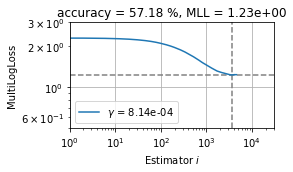

In [240]:
# plot loss development
hfLoss=plt.figure('Loss_vs_Epoch',figsize=(4,2.5))
hfLoss.clf()
plt.title("accuracy = {:.2f} %, MLL = {:.2e}".format(100*score,clf.best_score_['valid_0']['multi_logloss']))
axLoss=hfLoss.add_subplot(111)
plt.axhline(clf.best_score_['valid_0']['multi_logloss'], color = 'gray', linestyle='dashed',linewidth = 1.5)
plt.axvline(clf.best_iteration_, color = 'gray', linestyle='dashed',linewidth = 1.5)
axLoss.plot(clf.evals_result_['valid_0']['multi_logloss'], label='$\gamma$ = {:.2e}'.format(clf.learning_rate))
plt.ylim([0.5,3])
plt.xlim([1,params['n_estimators']])
plt.ylabel('MultiLogLoss')
plt.xlabel('Estimator $i$')
# plt.semilogy()
plt.loglog()
axLoss.legend(loc='best')
plt.tight_layout()

plt.grid()
# plt.savefig('BestParams_LossEvolution.')

# plt.savefig('plotsAfterGridsearch/BestParams_LossEvolution.png',dpi=200)
clf.get_params()

In [249]:
X_train.columns
X_test.columns

Index(['zerocrossing', 'spectralrolloff', 'chromagramstd', 'chromagrammean',
       'fourier_std', 'fourier_mean', 'chroma_cens', 'hardness', 'depth',
       'brightness', 'roughness', 'warmth', 'sharpness', 'boominess'],
      dtype='object')

In [14]:
# hyper parameter optimization 
# distributions = {
#                 'learning_rate':np.geomspace(1e-5,0.2,100), 
#                 'num_leaves':poisson(8),
#                 'max_depth': poisson(8)
#                 }
runGridSeach=0
if runGridSeach:
    GridSearchParameters = {'learning_rate':np.geomspace(9e-5,0.2,8), 'num_leaves':np.array([5,7,9,11,13]),'max_depth':np.array([6,8,10,12])}
    GridSearchClf = GridSearchCV(clf,GridSearchParameters,scoring='neg_log_loss', verbose=1, n_jobs=-1)
    GridSearchResults = GridSearchClf.fit(X_train, y_train, eval_set =[(X_val,y_val)],early_stopping_rounds = NstopRound)

# print(distributions['learning_rate'])
# distributions['learning_rate']

# scorer = make_scorer(log_loss, labels = [0,1,2,3,4,5,6,7,8,9])
# RanSearchclf = RandomizedSearchCV(clf, distributions, random_state=3,n_iter=NIters, scoring='neg_log_loss', verbose=1, n_jobs=-1)
# RanSearchResult = RanSearchclf.fit(X_train, y_train, eval_set =[(X_val,y_val)],early_stopping_rounds = NstopRound)



%notify -m "Hyper Parameter optimization done!"

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 116.3min
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 248.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 285.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 293.1min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed: 293.2min finished


[1]	valid_0's multi_logloss: 2.3015
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's multi_logloss: 2.29839
[3]	valid_0's multi_logloss: 2.29534
[4]	valid_0's multi_logloss: 2.2923
[5]	valid_0's multi_logloss: 2.2892
[6]	valid_0's multi_logloss: 2.28617
[7]	valid_0's multi_logloss: 2.28313
[8]	valid_0's multi_logloss: 2.28026
[9]	valid_0's multi_logloss: 2.27738
[10]	valid_0's multi_logloss: 2.27447
[11]	valid_0's multi_logloss: 2.27154
[12]	valid_0's multi_logloss: 2.26887
[13]	valid_0's multi_logloss: 2.26593
[14]	valid_0's multi_logloss: 2.26321
[15]	valid_0's multi_logloss: 2.26033
[16]	valid_0's multi_logloss: 2.25764
[17]	valid_0's multi_logloss: 2.25487
[18]	valid_0's multi_logloss: 2.25215
[19]	valid_0's multi_logloss: 2.24943
[20]	valid_0's multi_logloss: 2.24675
[21]	valid_0's multi_logloss: 2.24399
[22]	valid_0's multi_logloss: 2.24144
[23]	valid_0's multi_logloss: 2.23882
[24]	valid_0's multi_logloss: 2.2362
[25]	valid_0's multi_logloss: 2.23366


[242]	valid_0's multi_logloss: 1.84994
[243]	valid_0's multi_logloss: 1.84863
[244]	valid_0's multi_logloss: 1.84725
[245]	valid_0's multi_logloss: 1.84585
[246]	valid_0's multi_logloss: 1.84459
[247]	valid_0's multi_logloss: 1.84327
[248]	valid_0's multi_logloss: 1.84192
[249]	valid_0's multi_logloss: 1.84051
[250]	valid_0's multi_logloss: 1.83919
[251]	valid_0's multi_logloss: 1.83781
[252]	valid_0's multi_logloss: 1.8365
[253]	valid_0's multi_logloss: 1.83518
[254]	valid_0's multi_logloss: 1.83386
[255]	valid_0's multi_logloss: 1.83254
[256]	valid_0's multi_logloss: 1.83119
[257]	valid_0's multi_logloss: 1.82982
[258]	valid_0's multi_logloss: 1.82838
[259]	valid_0's multi_logloss: 1.8271
[260]	valid_0's multi_logloss: 1.8257
[261]	valid_0's multi_logloss: 1.82438
[262]	valid_0's multi_logloss: 1.82318
[263]	valid_0's multi_logloss: 1.82186
[264]	valid_0's multi_logloss: 1.82052
[265]	valid_0's multi_logloss: 1.8192
[266]	valid_0's multi_logloss: 1.81794
[267]	valid_0's multi_logloss

[461]	valid_0's multi_logloss: 1.61654
[462]	valid_0's multi_logloss: 1.61558
[463]	valid_0's multi_logloss: 1.61473
[464]	valid_0's multi_logloss: 1.61385
[465]	valid_0's multi_logloss: 1.61302
[466]	valid_0's multi_logloss: 1.61214
[467]	valid_0's multi_logloss: 1.61126
[468]	valid_0's multi_logloss: 1.61034
[469]	valid_0's multi_logloss: 1.60953
[470]	valid_0's multi_logloss: 1.60872
[471]	valid_0's multi_logloss: 1.60782
[472]	valid_0's multi_logloss: 1.60693
[473]	valid_0's multi_logloss: 1.60604
[474]	valid_0's multi_logloss: 1.60513
[475]	valid_0's multi_logloss: 1.60425
[476]	valid_0's multi_logloss: 1.60337
[477]	valid_0's multi_logloss: 1.60245
[478]	valid_0's multi_logloss: 1.60156
[479]	valid_0's multi_logloss: 1.60067
[480]	valid_0's multi_logloss: 1.59978
[481]	valid_0's multi_logloss: 1.59887
[482]	valid_0's multi_logloss: 1.59796
[483]	valid_0's multi_logloss: 1.59707
[484]	valid_0's multi_logloss: 1.59618
[485]	valid_0's multi_logloss: 1.59524
[486]	valid_0's multi_log

[683]	valid_0's multi_logloss: 1.44386
[684]	valid_0's multi_logloss: 1.44319
[685]	valid_0's multi_logloss: 1.44258
[686]	valid_0's multi_logloss: 1.44194
[687]	valid_0's multi_logloss: 1.44127
[688]	valid_0's multi_logloss: 1.44071
[689]	valid_0's multi_logloss: 1.44002
[690]	valid_0's multi_logloss: 1.43942
[691]	valid_0's multi_logloss: 1.43883
[692]	valid_0's multi_logloss: 1.43813
[693]	valid_0's multi_logloss: 1.43753
[694]	valid_0's multi_logloss: 1.43688
[695]	valid_0's multi_logloss: 1.43616
[696]	valid_0's multi_logloss: 1.43549
[697]	valid_0's multi_logloss: 1.4349
[698]	valid_0's multi_logloss: 1.43424
[699]	valid_0's multi_logloss: 1.43362
[700]	valid_0's multi_logloss: 1.43306
[701]	valid_0's multi_logloss: 1.43235
[702]	valid_0's multi_logloss: 1.43164
[703]	valid_0's multi_logloss: 1.431
[704]	valid_0's multi_logloss: 1.43033
[705]	valid_0's multi_logloss: 1.42968
[706]	valid_0's multi_logloss: 1.429
[707]	valid_0's multi_logloss: 1.42826
[708]	valid_0's multi_logloss:

[907]	valid_0's multi_logloss: 1.31838
[908]	valid_0's multi_logloss: 1.31791
[909]	valid_0's multi_logloss: 1.3174
[910]	valid_0's multi_logloss: 1.31702
[911]	valid_0's multi_logloss: 1.31653
[912]	valid_0's multi_logloss: 1.3161
[913]	valid_0's multi_logloss: 1.31563
[914]	valid_0's multi_logloss: 1.31521
[915]	valid_0's multi_logloss: 1.31476
[916]	valid_0's multi_logloss: 1.31428
[917]	valid_0's multi_logloss: 1.3139
[918]	valid_0's multi_logloss: 1.31347
[919]	valid_0's multi_logloss: 1.31298
[920]	valid_0's multi_logloss: 1.31252
[921]	valid_0's multi_logloss: 1.31206
[922]	valid_0's multi_logloss: 1.3116
[923]	valid_0's multi_logloss: 1.31119
[924]	valid_0's multi_logloss: 1.31074
[925]	valid_0's multi_logloss: 1.31025
[926]	valid_0's multi_logloss: 1.30985
[927]	valid_0's multi_logloss: 1.3094
[928]	valid_0's multi_logloss: 1.30895
[929]	valid_0's multi_logloss: 1.30854
[930]	valid_0's multi_logloss: 1.30815
[931]	valid_0's multi_logloss: 1.30776
[932]	valid_0's multi_logloss:

[1125]	valid_0's multi_logloss: 1.23355
[1126]	valid_0's multi_logloss: 1.23325
[1127]	valid_0's multi_logloss: 1.23283
[1128]	valid_0's multi_logloss: 1.23253
[1129]	valid_0's multi_logloss: 1.23217
[1130]	valid_0's multi_logloss: 1.23181
[1131]	valid_0's multi_logloss: 1.23151
[1132]	valid_0's multi_logloss: 1.23118
[1133]	valid_0's multi_logloss: 1.23078
[1134]	valid_0's multi_logloss: 1.23049
[1135]	valid_0's multi_logloss: 1.23009
[1136]	valid_0's multi_logloss: 1.22973
[1137]	valid_0's multi_logloss: 1.22934
[1138]	valid_0's multi_logloss: 1.229
[1139]	valid_0's multi_logloss: 1.22865
[1140]	valid_0's multi_logloss: 1.22833
[1141]	valid_0's multi_logloss: 1.228
[1142]	valid_0's multi_logloss: 1.22756
[1143]	valid_0's multi_logloss: 1.22729
[1144]	valid_0's multi_logloss: 1.2269
[1145]	valid_0's multi_logloss: 1.22657
[1146]	valid_0's multi_logloss: 1.22618
[1147]	valid_0's multi_logloss: 1.22584
[1148]	valid_0's multi_logloss: 1.2255
[1149]	valid_0's multi_logloss: 1.2251
[1150]	

[1344]	valid_0's multi_logloss: 1.16098
[1345]	valid_0's multi_logloss: 1.16065
[1346]	valid_0's multi_logloss: 1.16033
[1347]	valid_0's multi_logloss: 1.15996
[1348]	valid_0's multi_logloss: 1.15964
[1349]	valid_0's multi_logloss: 1.15928
[1350]	valid_0's multi_logloss: 1.15901
[1351]	valid_0's multi_logloss: 1.15864
[1352]	valid_0's multi_logloss: 1.15829
[1353]	valid_0's multi_logloss: 1.15794
[1354]	valid_0's multi_logloss: 1.15763
[1355]	valid_0's multi_logloss: 1.15729
[1356]	valid_0's multi_logloss: 1.15698
[1357]	valid_0's multi_logloss: 1.1566
[1358]	valid_0's multi_logloss: 1.15627
[1359]	valid_0's multi_logloss: 1.156
[1360]	valid_0's multi_logloss: 1.1557
[1361]	valid_0's multi_logloss: 1.15536
[1362]	valid_0's multi_logloss: 1.15504
[1363]	valid_0's multi_logloss: 1.15469
[1364]	valid_0's multi_logloss: 1.15437
[1365]	valid_0's multi_logloss: 1.15406
[1366]	valid_0's multi_logloss: 1.15374
[1367]	valid_0's multi_logloss: 1.15339
[1368]	valid_0's multi_logloss: 1.15309
[136

[1559]	valid_0's multi_logloss: 1.10222
[1560]	valid_0's multi_logloss: 1.102
[1561]	valid_0's multi_logloss: 1.10181
[1562]	valid_0's multi_logloss: 1.10158
[1563]	valid_0's multi_logloss: 1.10134
[1564]	valid_0's multi_logloss: 1.10114
[1565]	valid_0's multi_logloss: 1.10087
[1566]	valid_0's multi_logloss: 1.10068
[1567]	valid_0's multi_logloss: 1.10047
[1568]	valid_0's multi_logloss: 1.10026
[1569]	valid_0's multi_logloss: 1.10004
[1570]	valid_0's multi_logloss: 1.09986
[1571]	valid_0's multi_logloss: 1.0996
[1572]	valid_0's multi_logloss: 1.09937
[1573]	valid_0's multi_logloss: 1.09914
[1574]	valid_0's multi_logloss: 1.09887
[1575]	valid_0's multi_logloss: 1.09869
[1576]	valid_0's multi_logloss: 1.09842
[1577]	valid_0's multi_logloss: 1.09826
[1578]	valid_0's multi_logloss: 1.09803
[1579]	valid_0's multi_logloss: 1.09782
[1580]	valid_0's multi_logloss: 1.09758
[1581]	valid_0's multi_logloss: 1.09736
[1582]	valid_0's multi_logloss: 1.09718
[1583]	valid_0's multi_logloss: 1.09694
[15

[1773]	valid_0's multi_logloss: 1.06207
[1774]	valid_0's multi_logloss: 1.06189
[1775]	valid_0's multi_logloss: 1.06174
[1776]	valid_0's multi_logloss: 1.06154
[1777]	valid_0's multi_logloss: 1.0614
[1778]	valid_0's multi_logloss: 1.06125
[1779]	valid_0's multi_logloss: 1.06104
[1780]	valid_0's multi_logloss: 1.06087
[1781]	valid_0's multi_logloss: 1.06067
[1782]	valid_0's multi_logloss: 1.06049
[1783]	valid_0's multi_logloss: 1.06027
[1784]	valid_0's multi_logloss: 1.06013
[1785]	valid_0's multi_logloss: 1.05993
[1786]	valid_0's multi_logloss: 1.05978
[1787]	valid_0's multi_logloss: 1.05961
[1788]	valid_0's multi_logloss: 1.05943
[1789]	valid_0's multi_logloss: 1.05923
[1790]	valid_0's multi_logloss: 1.05905
[1791]	valid_0's multi_logloss: 1.05892
[1792]	valid_0's multi_logloss: 1.0587
[1793]	valid_0's multi_logloss: 1.05848
[1794]	valid_0's multi_logloss: 1.05832
[1795]	valid_0's multi_logloss: 1.05814
[1796]	valid_0's multi_logloss: 1.058
[1797]	valid_0's multi_logloss: 1.05781
[179

[1985]	valid_0's multi_logloss: 1.03073
[1986]	valid_0's multi_logloss: 1.0306
[1987]	valid_0's multi_logloss: 1.03049
[1988]	valid_0's multi_logloss: 1.03036
[1989]	valid_0's multi_logloss: 1.03023
[1990]	valid_0's multi_logloss: 1.03009
[1991]	valid_0's multi_logloss: 1.02993
[1992]	valid_0's multi_logloss: 1.02979
[1993]	valid_0's multi_logloss: 1.02968
[1994]	valid_0's multi_logloss: 1.02955
[1995]	valid_0's multi_logloss: 1.02946
[1996]	valid_0's multi_logloss: 1.02936
[1997]	valid_0's multi_logloss: 1.02922
[1998]	valid_0's multi_logloss: 1.02914
[1999]	valid_0's multi_logloss: 1.02903
[2000]	valid_0's multi_logloss: 1.02893
[2001]	valid_0's multi_logloss: 1.02882
[2002]	valid_0's multi_logloss: 1.02869
[2003]	valid_0's multi_logloss: 1.02859
[2004]	valid_0's multi_logloss: 1.02848
[2005]	valid_0's multi_logloss: 1.02839
[2006]	valid_0's multi_logloss: 1.02822
[2007]	valid_0's multi_logloss: 1.02812
[2008]	valid_0's multi_logloss: 1.028
[2009]	valid_0's multi_logloss: 1.02789
[20

[2203]	valid_0's multi_logloss: 1.00445
[2204]	valid_0's multi_logloss: 1.00434
[2205]	valid_0's multi_logloss: 1.00417
[2206]	valid_0's multi_logloss: 1.00408
[2207]	valid_0's multi_logloss: 1.00399
[2208]	valid_0's multi_logloss: 1.00381
[2209]	valid_0's multi_logloss: 1.00375
[2210]	valid_0's multi_logloss: 1.00366
[2211]	valid_0's multi_logloss: 1.00349
[2212]	valid_0's multi_logloss: 1.00336
[2213]	valid_0's multi_logloss: 1.00326
[2214]	valid_0's multi_logloss: 1.00313
[2215]	valid_0's multi_logloss: 1.00303
[2216]	valid_0's multi_logloss: 1.00298
[2217]	valid_0's multi_logloss: 1.00285
[2218]	valid_0's multi_logloss: 1.00275
[2219]	valid_0's multi_logloss: 1.00262
[2220]	valid_0's multi_logloss: 1.00248
[2221]	valid_0's multi_logloss: 1.00235
[2222]	valid_0's multi_logloss: 1.00225
[2223]	valid_0's multi_logloss: 1.00212
[2224]	valid_0's multi_logloss: 1.00203
[2225]	valid_0's multi_logloss: 1.00195
[2226]	valid_0's multi_logloss: 1.00183
[2227]	valid_0's multi_logloss: 1.0017
[

[2417]	valid_0's multi_logloss: 0.984797
[2418]	valid_0's multi_logloss: 0.984734
[2419]	valid_0's multi_logloss: 0.98467
[2420]	valid_0's multi_logloss: 0.98457
[2421]	valid_0's multi_logloss: 0.984515
[2422]	valid_0's multi_logloss: 0.984485
[2423]	valid_0's multi_logloss: 0.984405
[2424]	valid_0's multi_logloss: 0.984323
[2425]	valid_0's multi_logloss: 0.984259
[2426]	valid_0's multi_logloss: 0.984191
[2427]	valid_0's multi_logloss: 0.984105
[2428]	valid_0's multi_logloss: 0.98401
[2429]	valid_0's multi_logloss: 0.983935
[2430]	valid_0's multi_logloss: 0.983878
[2431]	valid_0's multi_logloss: 0.983759
[2432]	valid_0's multi_logloss: 0.98365
[2433]	valid_0's multi_logloss: 0.983588
[2434]	valid_0's multi_logloss: 0.983541
[2435]	valid_0's multi_logloss: 0.983395
[2436]	valid_0's multi_logloss: 0.983286
[2437]	valid_0's multi_logloss: 0.983238
[2438]	valid_0's multi_logloss: 0.983142
[2439]	valid_0's multi_logloss: 0.983082
[2440]	valid_0's multi_logloss: 0.983007
[2441]	valid_0's mul

[2631]	valid_0's multi_logloss: 0.968646
[2632]	valid_0's multi_logloss: 0.968556
[2633]	valid_0's multi_logloss: 0.968487
[2634]	valid_0's multi_logloss: 0.968423
[2635]	valid_0's multi_logloss: 0.968398
[2636]	valid_0's multi_logloss: 0.968321
[2637]	valid_0's multi_logloss: 0.968247
[2638]	valid_0's multi_logloss: 0.968185
[2639]	valid_0's multi_logloss: 0.968064
[2640]	valid_0's multi_logloss: 0.967992
[2641]	valid_0's multi_logloss: 0.967918
[2642]	valid_0's multi_logloss: 0.96779
[2643]	valid_0's multi_logloss: 0.967688
[2644]	valid_0's multi_logloss: 0.967618
[2645]	valid_0's multi_logloss: 0.967548
[2646]	valid_0's multi_logloss: 0.967488
[2647]	valid_0's multi_logloss: 0.967404
[2648]	valid_0's multi_logloss: 0.967331
[2649]	valid_0's multi_logloss: 0.967203
[2650]	valid_0's multi_logloss: 0.967185
[2651]	valid_0's multi_logloss: 0.967131
[2652]	valid_0's multi_logloss: 0.967057
[2653]	valid_0's multi_logloss: 0.966928
[2654]	valid_0's multi_logloss: 0.966868
[2655]	valid_0's 

[2838]	valid_0's multi_logloss: 0.956933
[2839]	valid_0's multi_logloss: 0.956864
[2840]	valid_0's multi_logloss: 0.956801
[2841]	valid_0's multi_logloss: 0.956739
[2842]	valid_0's multi_logloss: 0.956685
[2843]	valid_0's multi_logloss: 0.956621
[2844]	valid_0's multi_logloss: 0.956554
[2845]	valid_0's multi_logloss: 0.956556
[2846]	valid_0's multi_logloss: 0.956533
[2847]	valid_0's multi_logloss: 0.956424
[2848]	valid_0's multi_logloss: 0.956361
[2849]	valid_0's multi_logloss: 0.956321
[2850]	valid_0's multi_logloss: 0.956259
[2851]	valid_0's multi_logloss: 0.956218
[2852]	valid_0's multi_logloss: 0.956154
[2853]	valid_0's multi_logloss: 0.956066
[2854]	valid_0's multi_logloss: 0.956095
[2855]	valid_0's multi_logloss: 0.956046
[2856]	valid_0's multi_logloss: 0.956012
[2857]	valid_0's multi_logloss: 0.955931
[2858]	valid_0's multi_logloss: 0.955858
[2859]	valid_0's multi_logloss: 0.955819
[2860]	valid_0's multi_logloss: 0.955764
[2861]	valid_0's multi_logloss: 0.955704
[2862]	valid_0's

[3051]	valid_0's multi_logloss: 0.945786
[3052]	valid_0's multi_logloss: 0.945729
[3053]	valid_0's multi_logloss: 0.945663
[3054]	valid_0's multi_logloss: 0.945592
[3055]	valid_0's multi_logloss: 0.945529
[3056]	valid_0's multi_logloss: 0.945536
[3057]	valid_0's multi_logloss: 0.945459
[3058]	valid_0's multi_logloss: 0.945388
[3059]	valid_0's multi_logloss: 0.945363
[3060]	valid_0's multi_logloss: 0.945296
[3061]	valid_0's multi_logloss: 0.945265
[3062]	valid_0's multi_logloss: 0.945209
[3063]	valid_0's multi_logloss: 0.945155
[3064]	valid_0's multi_logloss: 0.945107
[3065]	valid_0's multi_logloss: 0.945049
[3066]	valid_0's multi_logloss: 0.945007
[3067]	valid_0's multi_logloss: 0.94495
[3068]	valid_0's multi_logloss: 0.944937
[3069]	valid_0's multi_logloss: 0.944898
[3070]	valid_0's multi_logloss: 0.94483
[3071]	valid_0's multi_logloss: 0.944761
[3072]	valid_0's multi_logloss: 0.944704
[3073]	valid_0's multi_logloss: 0.944642
[3074]	valid_0's multi_logloss: 0.944572
[3075]	valid_0's m

[3259]	valid_0's multi_logloss: 0.939029
[3260]	valid_0's multi_logloss: 0.939022
[3261]	valid_0's multi_logloss: 0.939022
[3262]	valid_0's multi_logloss: 0.938976
[3263]	valid_0's multi_logloss: 0.938957
[3264]	valid_0's multi_logloss: 0.938912
[3265]	valid_0's multi_logloss: 0.938873
[3266]	valid_0's multi_logloss: 0.938832
[3267]	valid_0's multi_logloss: 0.938785
[3268]	valid_0's multi_logloss: 0.938784
[3269]	valid_0's multi_logloss: 0.938774
[3270]	valid_0's multi_logloss: 0.938759
[3271]	valid_0's multi_logloss: 0.93873
[3272]	valid_0's multi_logloss: 0.938723
[3273]	valid_0's multi_logloss: 0.938681
[3274]	valid_0's multi_logloss: 0.93865
[3275]	valid_0's multi_logloss: 0.938594
[3276]	valid_0's multi_logloss: 0.938565
[3277]	valid_0's multi_logloss: 0.938493
[3278]	valid_0's multi_logloss: 0.938432
[3279]	valid_0's multi_logloss: 0.938405
[3280]	valid_0's multi_logloss: 0.938401
[3281]	valid_0's multi_logloss: 0.938336
[3282]	valid_0's multi_logloss: 0.938278
[3283]	valid_0's m

[3471]	valid_0's multi_logloss: 0.934853
[3472]	valid_0's multi_logloss: 0.934794
[3473]	valid_0's multi_logloss: 0.934748
[3474]	valid_0's multi_logloss: 0.93476
[3475]	valid_0's multi_logloss: 0.934752
[3476]	valid_0's multi_logloss: 0.934784
[3477]	valid_0's multi_logloss: 0.934789
[3478]	valid_0's multi_logloss: 0.934759
[3479]	valid_0's multi_logloss: 0.934779
[3480]	valid_0's multi_logloss: 0.934781
[3481]	valid_0's multi_logloss: 0.934721
[3482]	valid_0's multi_logloss: 0.934687
[3483]	valid_0's multi_logloss: 0.93463
[3484]	valid_0's multi_logloss: 0.934648
[3485]	valid_0's multi_logloss: 0.934656
[3486]	valid_0's multi_logloss: 0.934654
[3487]	valid_0's multi_logloss: 0.934614
[3488]	valid_0's multi_logloss: 0.934611
[3489]	valid_0's multi_logloss: 0.934577
[3490]	valid_0's multi_logloss: 0.93455
[3491]	valid_0's multi_logloss: 0.934582
[3492]	valid_0's multi_logloss: 0.934569
[3493]	valid_0's multi_logloss: 0.934574
[3494]	valid_0's multi_logloss: 0.93459
[3495]	valid_0's mul

[3678]	valid_0's multi_logloss: 0.929944
[3679]	valid_0's multi_logloss: 0.929912
[3680]	valid_0's multi_logloss: 0.92989
[3681]	valid_0's multi_logloss: 0.929888
[3682]	valid_0's multi_logloss: 0.929903
[3683]	valid_0's multi_logloss: 0.929904
[3684]	valid_0's multi_logloss: 0.929867
[3685]	valid_0's multi_logloss: 0.929848
[3686]	valid_0's multi_logloss: 0.929791
[3687]	valid_0's multi_logloss: 0.929789
[3688]	valid_0's multi_logloss: 0.929785
[3689]	valid_0's multi_logloss: 0.929784
[3690]	valid_0's multi_logloss: 0.929716
[3691]	valid_0's multi_logloss: 0.929666
[3692]	valid_0's multi_logloss: 0.929719
[3693]	valid_0's multi_logloss: 0.929703
[3694]	valid_0's multi_logloss: 0.929648
[3695]	valid_0's multi_logloss: 0.929641
[3696]	valid_0's multi_logloss: 0.929636
[3697]	valid_0's multi_logloss: 0.929644
[3698]	valid_0's multi_logloss: 0.929637
[3699]	valid_0's multi_logloss: 0.929626
[3700]	valid_0's multi_logloss: 0.929582
[3701]	valid_0's multi_logloss: 0.929534
[3702]	valid_0's 

[3890]	valid_0's multi_logloss: 0.929304
[3891]	valid_0's multi_logloss: 0.929254
[3892]	valid_0's multi_logloss: 0.929221
[3893]	valid_0's multi_logloss: 0.929186
[3894]	valid_0's multi_logloss: 0.929217
[3895]	valid_0's multi_logloss: 0.929164
[3896]	valid_0's multi_logloss: 0.929144
[3897]	valid_0's multi_logloss: 0.929143
[3898]	valid_0's multi_logloss: 0.929065
[3899]	valid_0's multi_logloss: 0.929097
[3900]	valid_0's multi_logloss: 0.929071
[3901]	valid_0's multi_logloss: 0.929028
[3902]	valid_0's multi_logloss: 0.928958
[3903]	valid_0's multi_logloss: 0.928974
[3904]	valid_0's multi_logloss: 0.929
[3905]	valid_0's multi_logloss: 0.928908
[3906]	valid_0's multi_logloss: 0.928857
[3907]	valid_0's multi_logloss: 0.928931
[3908]	valid_0's multi_logloss: 0.928925
[3909]	valid_0's multi_logloss: 0.928886
[3910]	valid_0's multi_logloss: 0.928834
[3911]	valid_0's multi_logloss: 0.928838
[3912]	valid_0's multi_logloss: 0.928833
[3913]	valid_0's multi_logloss: 0.928849
[3914]	valid_0's mu

[4092]	valid_0's multi_logloss: 0.929303
[4093]	valid_0's multi_logloss: 0.929314
[4094]	valid_0's multi_logloss: 0.929233
[4095]	valid_0's multi_logloss: 0.929251
[4096]	valid_0's multi_logloss: 0.92923
[4097]	valid_0's multi_logloss: 0.929225
[4098]	valid_0's multi_logloss: 0.929237
[4099]	valid_0's multi_logloss: 0.929238
[4100]	valid_0's multi_logloss: 0.929232
[4101]	valid_0's multi_logloss: 0.929225
[4102]	valid_0's multi_logloss: 0.929192
[4103]	valid_0's multi_logloss: 0.929184
[4104]	valid_0's multi_logloss: 0.929212
[4105]	valid_0's multi_logloss: 0.929184
[4106]	valid_0's multi_logloss: 0.92923
[4107]	valid_0's multi_logloss: 0.929294
[4108]	valid_0's multi_logloss: 0.929299
[4109]	valid_0's multi_logloss: 0.929215
[4110]	valid_0's multi_logloss: 0.929251
[4111]	valid_0's multi_logloss: 0.929253
[4112]	valid_0's multi_logloss: 0.929198
[4113]	valid_0's multi_logloss: 0.929224
[4114]	valid_0's multi_logloss: 0.929235
[4115]	valid_0's multi_logloss: 0.929205
[4116]	valid_0's m

[4327]	valid_0's multi_logloss: 0.926893
[4328]	valid_0's multi_logloss: 0.926914
[4329]	valid_0's multi_logloss: 0.9269
[4330]	valid_0's multi_logloss: 0.926914
[4331]	valid_0's multi_logloss: 0.926891
[4332]	valid_0's multi_logloss: 0.926816
[4333]	valid_0's multi_logloss: 0.926842
[4334]	valid_0's multi_logloss: 0.926833
[4335]	valid_0's multi_logloss: 0.926841
[4336]	valid_0's multi_logloss: 0.9268
[4337]	valid_0's multi_logloss: 0.926829
[4338]	valid_0's multi_logloss: 0.926817
[4339]	valid_0's multi_logloss: 0.926775
[4340]	valid_0's multi_logloss: 0.926838
[4341]	valid_0's multi_logloss: 0.926811
[4342]	valid_0's multi_logloss: 0.926783
[4343]	valid_0's multi_logloss: 0.92674
[4344]	valid_0's multi_logloss: 0.926703
[4345]	valid_0's multi_logloss: 0.926715
[4346]	valid_0's multi_logloss: 0.926768
[4347]	valid_0's multi_logloss: 0.926756
[4348]	valid_0's multi_logloss: 0.926755
[4349]	valid_0's multi_logloss: 0.926744
[4350]	valid_0's multi_logloss: 0.926782
[4351]	valid_0's mult

[4571]	valid_0's multi_logloss: 0.926693
[4572]	valid_0's multi_logloss: 0.926702
[4573]	valid_0's multi_logloss: 0.926729
[4574]	valid_0's multi_logloss: 0.926708
[4575]	valid_0's multi_logloss: 0.926722
[4576]	valid_0's multi_logloss: 0.926763
[4577]	valid_0's multi_logloss: 0.92679
[4578]	valid_0's multi_logloss: 0.926779
[4579]	valid_0's multi_logloss: 0.92683
[4580]	valid_0's multi_logloss: 0.926794
[4581]	valid_0's multi_logloss: 0.926807
[4582]	valid_0's multi_logloss: 0.926808
[4583]	valid_0's multi_logloss: 0.926843
[4584]	valid_0's multi_logloss: 0.926865
[4585]	valid_0's multi_logloss: 0.926868
[4586]	valid_0's multi_logloss: 0.926889
[4587]	valid_0's multi_logloss: 0.926886
[4588]	valid_0's multi_logloss: 0.926919
[4589]	valid_0's multi_logloss: 0.926916
[4590]	valid_0's multi_logloss: 0.926911
[4591]	valid_0's multi_logloss: 0.926983
[4592]	valid_0's multi_logloss: 0.927
[4593]	valid_0's multi_logloss: 0.92702
[4594]	valid_0's multi_logloss: 0.927039
[4595]	valid_0's multi

[4791]	valid_0's multi_logloss: 0.930044
[4792]	valid_0's multi_logloss: 0.93005
[4793]	valid_0's multi_logloss: 0.930052
[4794]	valid_0's multi_logloss: 0.930099
[4795]	valid_0's multi_logloss: 0.930098
[4796]	valid_0's multi_logloss: 0.930141
[4797]	valid_0's multi_logloss: 0.930123
[4798]	valid_0's multi_logloss: 0.930181
[4799]	valid_0's multi_logloss: 0.930146
[4800]	valid_0's multi_logloss: 0.930149
[4801]	valid_0's multi_logloss: 0.930125
[4802]	valid_0's multi_logloss: 0.930149
[4803]	valid_0's multi_logloss: 0.930179
[4804]	valid_0's multi_logloss: 0.930193
[4805]	valid_0's multi_logloss: 0.930152
[4806]	valid_0's multi_logloss: 0.930135
[4807]	valid_0's multi_logloss: 0.930109
[4808]	valid_0's multi_logloss: 0.930121
[4809]	valid_0's multi_logloss: 0.930118
[4810]	valid_0's multi_logloss: 0.930139
[4811]	valid_0's multi_logloss: 0.930204
[4812]	valid_0's multi_logloss: 0.930236
[4813]	valid_0's multi_logloss: 0.930204
[4814]	valid_0's multi_logloss: 0.930203
[4815]	valid_0's 

[5021]	valid_0's multi_logloss: 0.931376
[5022]	valid_0's multi_logloss: 0.931411
[5023]	valid_0's multi_logloss: 0.931421
[5024]	valid_0's multi_logloss: 0.931463
[5025]	valid_0's multi_logloss: 0.93145
[5026]	valid_0's multi_logloss: 0.931509
[5027]	valid_0's multi_logloss: 0.931527
[5028]	valid_0's multi_logloss: 0.931511
[5029]	valid_0's multi_logloss: 0.931542
[5030]	valid_0's multi_logloss: 0.931517
[5031]	valid_0's multi_logloss: 0.931563
[5032]	valid_0's multi_logloss: 0.931565
[5033]	valid_0's multi_logloss: 0.931585
[5034]	valid_0's multi_logloss: 0.931632
[5035]	valid_0's multi_logloss: 0.931608
[5036]	valid_0's multi_logloss: 0.931625
[5037]	valid_0's multi_logloss: 0.931673
[5038]	valid_0's multi_logloss: 0.93167
[5039]	valid_0's multi_logloss: 0.931673
[5040]	valid_0's multi_logloss: 0.93169
[5041]	valid_0's multi_logloss: 0.931746
[5042]	valid_0's multi_logloss: 0.931772
[5043]	valid_0's multi_logloss: 0.931818
[5044]	valid_0's multi_logloss: 0.931791
[5045]	valid_0's mu

[5256]	valid_0's multi_logloss: 0.935649
[5257]	valid_0's multi_logloss: 0.935677
[5258]	valid_0's multi_logloss: 0.935679
[5259]	valid_0's multi_logloss: 0.93572
[5260]	valid_0's multi_logloss: 0.935713
[5261]	valid_0's multi_logloss: 0.93575
[5262]	valid_0's multi_logloss: 0.935774
[5263]	valid_0's multi_logloss: 0.935777
[5264]	valid_0's multi_logloss: 0.935805
[5265]	valid_0's multi_logloss: 0.935852
[5266]	valid_0's multi_logloss: 0.935845
[5267]	valid_0's multi_logloss: 0.93586
[5268]	valid_0's multi_logloss: 0.935886
[5269]	valid_0's multi_logloss: 0.935893
[5270]	valid_0's multi_logloss: 0.935898
[5271]	valid_0's multi_logloss: 0.935897
[5272]	valid_0's multi_logloss: 0.935926
[5273]	valid_0's multi_logloss: 0.935957
[5274]	valid_0's multi_logloss: 0.936006
[5275]	valid_0's multi_logloss: 0.936018
[5276]	valid_0's multi_logloss: 0.936017
[5277]	valid_0's multi_logloss: 0.936054
[5278]	valid_0's multi_logloss: 0.936084
[5279]	valid_0's multi_logloss: 0.936121
[5280]	valid_0's mu

<IPython.core.display.Javascript object>

1.0263739252504815
{'learning_rate': 0.0008137059759269703, 'max_depth': 6, 'num_leaves': 9}
(160,)


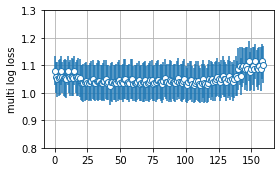

In [153]:
GridSearchResult=GridSearchResults
print(-1*GridSearchResult.best_score_)
print(GridSearchResult.best_params_)
print(np.shape(GridSearchResult.cv_results_['mean_test_score']))
plt.figure(figsize=(4,2.5))

# plt.plot(-1*RanSearchResult.)

plt.errorbar(np.arange(0,len(GridSearchResult.cv_results_['mean_test_score']),1),-1*GridSearchResult.cv_results_['mean_test_score'], yerr=GridSearchResult.cv_results_['std_test_score']/np.sqrt(5),marker ='o',
            markerfacecolor='w')

# plt.plot(np.arange(0,160,1),np.ones_like(GridSearchResult.cv_results_['mean_test_score'])*-1*np.mean(GridSearchResult.cv_results_['mean_test_score']),'k')
# 
plt.ylim([0.8,1.3])
plt.grid()
plt.tight_layout()
plt.ylabel('multi log loss')

# print(GridSearchResult.cv_results_)
# GridSearchResult.cv_results_['mean_test_score']
len(GridSearchResult.cv_results_)
GridSearchResult.best_params_
plt.tight_layout()
plt.savefig('plotsAfterGridsearch/TrainingLoss.png',dpi=200)

In [133]:
GridSearchResult.cv_results_

{'mean_fit_time': array([1357.93423753, 2090.20163646, 2575.6433239 , 2183.50103111,
        1546.18917747,  423.35324821,  535.41669588,  600.87132988,
         659.5271368 ,  739.40210457,  362.85654445,  466.89755702,
         570.37681522,  634.74812031,  735.84633503,  348.58067012,
         462.64383001,  584.78861275,  965.6070045 , 1511.62559767,
         352.57742963,  227.83003817,  232.59430103,  251.58820796,
         268.47746711,  196.11136923,  226.15131598,  229.79211354,
         253.92051296,  286.81797652,  190.10610204,  214.33358412,
         207.79038014,  251.70900178,  269.42358627,  186.3953908 ,
         221.51596222,  215.18425512,  265.54207292,  298.26782289,
          74.74797039,   82.93887753,   93.12373128,   96.99889269,
         109.42258315,   70.60676465,   80.58314815,   90.00323887,
          97.57924094,  109.43279243,   71.29480829,   80.24621134,
         100.39998541,  116.16034541,  107.86697044,   71.81823092,
          80.51719432,   90.366

In [250]:
# clf.set_params(**RanSearchResult.best_params_)
# clf.set_params(**GridSearchResult.best_params_)
clf.fit(X_train, y_train, eval_set =[(X_val,y_val)], early_stopping_rounds=NstopRound)
y_pred_1=clf.predict(X_test)


scoref1 = f1_score(y_pred_1,y_test,average=None).mean()
score = precision_score(y_pred_1,y_test,average=None).mean()
print(score)
print(scoref1)
clf.get_params()

[1]	valid_0's multi_logloss: 2.3022
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's multi_logloss: 2.29976
[3]	valid_0's multi_logloss: 2.29733
[4]	valid_0's multi_logloss: 2.29492
[5]	valid_0's multi_logloss: 2.29252
[6]	valid_0's multi_logloss: 2.29015
[7]	valid_0's multi_logloss: 2.28783
[8]	valid_0's multi_logloss: 2.28549
[9]	valid_0's multi_logloss: 2.28319
[10]	valid_0's multi_logloss: 2.28087
[11]	valid_0's multi_logloss: 2.27853
[12]	valid_0's multi_logloss: 2.27629
[13]	valid_0's multi_logloss: 2.27398
[14]	valid_0's multi_logloss: 2.27173
[15]	valid_0's multi_logloss: 2.26942
[16]	valid_0's multi_logloss: 2.26719
[17]	valid_0's multi_logloss: 2.26491
[18]	valid_0's multi_logloss: 2.26268
[19]	valid_0's multi_logloss: 2.26048
[20]	valid_0's multi_logloss: 2.25822
[21]	valid_0's multi_logloss: 2.25602
[22]	valid_0's multi_logloss: 2.2538
[23]	valid_0's multi_logloss: 2.2516
[24]	valid_0's multi_logloss: 2.24941
[25]	valid_0's multi_logloss: 2.24718

[217]	valid_0's multi_logloss: 1.94178
[218]	valid_0's multi_logloss: 1.94063
[219]	valid_0's multi_logloss: 1.9395
[220]	valid_0's multi_logloss: 1.93833
[221]	valid_0's multi_logloss: 1.93717
[222]	valid_0's multi_logloss: 1.93602
[223]	valid_0's multi_logloss: 1.93488
[224]	valid_0's multi_logloss: 1.93375
[225]	valid_0's multi_logloss: 1.93255
[226]	valid_0's multi_logloss: 1.93144
[227]	valid_0's multi_logloss: 1.93031
[228]	valid_0's multi_logloss: 1.92916
[229]	valid_0's multi_logloss: 1.92803
[230]	valid_0's multi_logloss: 1.92694
[231]	valid_0's multi_logloss: 1.92579
[232]	valid_0's multi_logloss: 1.92466
[233]	valid_0's multi_logloss: 1.92359
[234]	valid_0's multi_logloss: 1.92246
[235]	valid_0's multi_logloss: 1.92134
[236]	valid_0's multi_logloss: 1.92023
[237]	valid_0's multi_logloss: 1.91912
[238]	valid_0's multi_logloss: 1.91806
[239]	valid_0's multi_logloss: 1.91693
[240]	valid_0's multi_logloss: 1.91583
[241]	valid_0's multi_logloss: 1.91472
[242]	valid_0's multi_logl

[454]	valid_0's multi_logloss: 1.72058
[455]	valid_0's multi_logloss: 1.71997
[456]	valid_0's multi_logloss: 1.71926
[457]	valid_0's multi_logloss: 1.71861
[458]	valid_0's multi_logloss: 1.71784
[459]	valid_0's multi_logloss: 1.71709
[460]	valid_0's multi_logloss: 1.71638
[461]	valid_0's multi_logloss: 1.71575
[462]	valid_0's multi_logloss: 1.71497
[463]	valid_0's multi_logloss: 1.7143
[464]	valid_0's multi_logloss: 1.71356
[465]	valid_0's multi_logloss: 1.71288
[466]	valid_0's multi_logloss: 1.71216
[467]	valid_0's multi_logloss: 1.71151
[468]	valid_0's multi_logloss: 1.71079
[469]	valid_0's multi_logloss: 1.71007
[470]	valid_0's multi_logloss: 1.70941
[471]	valid_0's multi_logloss: 1.70869
[472]	valid_0's multi_logloss: 1.70801
[473]	valid_0's multi_logloss: 1.70732
[474]	valid_0's multi_logloss: 1.70661
[475]	valid_0's multi_logloss: 1.70589
[476]	valid_0's multi_logloss: 1.70527
[477]	valid_0's multi_logloss: 1.70452
[478]	valid_0's multi_logloss: 1.70383
[479]	valid_0's multi_logl

[678]	valid_0's multi_logloss: 1.58468
[679]	valid_0's multi_logloss: 1.58412
[680]	valid_0's multi_logloss: 1.58359
[681]	valid_0's multi_logloss: 1.58301
[682]	valid_0's multi_logloss: 1.5825
[683]	valid_0's multi_logloss: 1.58193
[684]	valid_0's multi_logloss: 1.58136
[685]	valid_0's multi_logloss: 1.58078
[686]	valid_0's multi_logloss: 1.58029
[687]	valid_0's multi_logloss: 1.57976
[688]	valid_0's multi_logloss: 1.57926
[689]	valid_0's multi_logloss: 1.57872
[690]	valid_0's multi_logloss: 1.57823
[691]	valid_0's multi_logloss: 1.57774
[692]	valid_0's multi_logloss: 1.57715
[693]	valid_0's multi_logloss: 1.57664
[694]	valid_0's multi_logloss: 1.57618
[695]	valid_0's multi_logloss: 1.57567
[696]	valid_0's multi_logloss: 1.57516
[697]	valid_0's multi_logloss: 1.57465
[698]	valid_0's multi_logloss: 1.57413
[699]	valid_0's multi_logloss: 1.57358
[700]	valid_0's multi_logloss: 1.57313
[701]	valid_0's multi_logloss: 1.57264
[702]	valid_0's multi_logloss: 1.57211
[703]	valid_0's multi_logl

[912]	valid_0's multi_logloss: 1.4844
[913]	valid_0's multi_logloss: 1.48412
[914]	valid_0's multi_logloss: 1.48376
[915]	valid_0's multi_logloss: 1.48335
[916]	valid_0's multi_logloss: 1.48305
[917]	valid_0's multi_logloss: 1.48278
[918]	valid_0's multi_logloss: 1.48238
[919]	valid_0's multi_logloss: 1.48205
[920]	valid_0's multi_logloss: 1.48171
[921]	valid_0's multi_logloss: 1.48136
[922]	valid_0's multi_logloss: 1.48104
[923]	valid_0's multi_logloss: 1.48065
[924]	valid_0's multi_logloss: 1.48035
[925]	valid_0's multi_logloss: 1.48005
[926]	valid_0's multi_logloss: 1.47976
[927]	valid_0's multi_logloss: 1.47942
[928]	valid_0's multi_logloss: 1.47906
[929]	valid_0's multi_logloss: 1.47871
[930]	valid_0's multi_logloss: 1.47836
[931]	valid_0's multi_logloss: 1.47798
[932]	valid_0's multi_logloss: 1.47767
[933]	valid_0's multi_logloss: 1.47737
[934]	valid_0's multi_logloss: 1.477
[935]	valid_0's multi_logloss: 1.47663
[936]	valid_0's multi_logloss: 1.47637
[937]	valid_0's multi_loglos

[1139]	valid_0's multi_logloss: 1.41946
[1140]	valid_0's multi_logloss: 1.41924
[1141]	valid_0's multi_logloss: 1.41899
[1142]	valid_0's multi_logloss: 1.41878
[1143]	valid_0's multi_logloss: 1.41847
[1144]	valid_0's multi_logloss: 1.41826
[1145]	valid_0's multi_logloss: 1.41801
[1146]	valid_0's multi_logloss: 1.41786
[1147]	valid_0's multi_logloss: 1.41757
[1148]	valid_0's multi_logloss: 1.41735
[1149]	valid_0's multi_logloss: 1.41716
[1150]	valid_0's multi_logloss: 1.41688
[1151]	valid_0's multi_logloss: 1.41664
[1152]	valid_0's multi_logloss: 1.41636
[1153]	valid_0's multi_logloss: 1.41619
[1154]	valid_0's multi_logloss: 1.41597
[1155]	valid_0's multi_logloss: 1.41575
[1156]	valid_0's multi_logloss: 1.41553
[1157]	valid_0's multi_logloss: 1.41529
[1158]	valid_0's multi_logloss: 1.41506
[1159]	valid_0's multi_logloss: 1.41484
[1160]	valid_0's multi_logloss: 1.41457
[1161]	valid_0's multi_logloss: 1.41438
[1162]	valid_0's multi_logloss: 1.41415
[1163]	valid_0's multi_logloss: 1.41394


[1366]	valid_0's multi_logloss: 1.37058
[1367]	valid_0's multi_logloss: 1.37047
[1368]	valid_0's multi_logloss: 1.37024
[1369]	valid_0's multi_logloss: 1.37002
[1370]	valid_0's multi_logloss: 1.3698
[1371]	valid_0's multi_logloss: 1.36962
[1372]	valid_0's multi_logloss: 1.36939
[1373]	valid_0's multi_logloss: 1.36915
[1374]	valid_0's multi_logloss: 1.36892
[1375]	valid_0's multi_logloss: 1.36881
[1376]	valid_0's multi_logloss: 1.3686
[1377]	valid_0's multi_logloss: 1.36832
[1378]	valid_0's multi_logloss: 1.36817
[1379]	valid_0's multi_logloss: 1.36797
[1380]	valid_0's multi_logloss: 1.36781
[1381]	valid_0's multi_logloss: 1.36756
[1382]	valid_0's multi_logloss: 1.36734
[1383]	valid_0's multi_logloss: 1.36711
[1384]	valid_0's multi_logloss: 1.36691
[1385]	valid_0's multi_logloss: 1.36671
[1386]	valid_0's multi_logloss: 1.3665
[1387]	valid_0's multi_logloss: 1.36629
[1388]	valid_0's multi_logloss: 1.36606
[1389]	valid_0's multi_logloss: 1.36586
[1390]	valid_0's multi_logloss: 1.36567
[13

[1576]	valid_0's multi_logloss: 1.33286
[1577]	valid_0's multi_logloss: 1.33272
[1578]	valid_0's multi_logloss: 1.33266
[1579]	valid_0's multi_logloss: 1.33249
[1580]	valid_0's multi_logloss: 1.33239
[1581]	valid_0's multi_logloss: 1.33216
[1582]	valid_0's multi_logloss: 1.33202
[1583]	valid_0's multi_logloss: 1.33184
[1584]	valid_0's multi_logloss: 1.33175
[1585]	valid_0's multi_logloss: 1.33158
[1586]	valid_0's multi_logloss: 1.33144
[1587]	valid_0's multi_logloss: 1.33132
[1588]	valid_0's multi_logloss: 1.33119
[1589]	valid_0's multi_logloss: 1.33107
[1590]	valid_0's multi_logloss: 1.33091
[1591]	valid_0's multi_logloss: 1.33076
[1592]	valid_0's multi_logloss: 1.33059
[1593]	valid_0's multi_logloss: 1.33046
[1594]	valid_0's multi_logloss: 1.3303
[1595]	valid_0's multi_logloss: 1.33017
[1596]	valid_0's multi_logloss: 1.33001
[1597]	valid_0's multi_logloss: 1.32983
[1598]	valid_0's multi_logloss: 1.32971
[1599]	valid_0's multi_logloss: 1.32952
[1600]	valid_0's multi_logloss: 1.32934
[

[1795]	valid_0's multi_logloss: 1.30696
[1796]	valid_0's multi_logloss: 1.30686
[1797]	valid_0's multi_logloss: 1.30677
[1798]	valid_0's multi_logloss: 1.30664
[1799]	valid_0's multi_logloss: 1.30651
[1800]	valid_0's multi_logloss: 1.30642
[1801]	valid_0's multi_logloss: 1.30636
[1802]	valid_0's multi_logloss: 1.30625
[1803]	valid_0's multi_logloss: 1.30615
[1804]	valid_0's multi_logloss: 1.30603
[1805]	valid_0's multi_logloss: 1.30595
[1806]	valid_0's multi_logloss: 1.30585
[1807]	valid_0's multi_logloss: 1.30576
[1808]	valid_0's multi_logloss: 1.30566
[1809]	valid_0's multi_logloss: 1.30558
[1810]	valid_0's multi_logloss: 1.30548
[1811]	valid_0's multi_logloss: 1.30536
[1812]	valid_0's multi_logloss: 1.30527
[1813]	valid_0's multi_logloss: 1.30514
[1814]	valid_0's multi_logloss: 1.30505
[1815]	valid_0's multi_logloss: 1.30494
[1816]	valid_0's multi_logloss: 1.30485
[1817]	valid_0's multi_logloss: 1.30478
[1818]	valid_0's multi_logloss: 1.30466
[1819]	valid_0's multi_logloss: 1.30455


[2009]	valid_0's multi_logloss: 1.29165
[2010]	valid_0's multi_logloss: 1.29164
[2011]	valid_0's multi_logloss: 1.29154
[2012]	valid_0's multi_logloss: 1.2915
[2013]	valid_0's multi_logloss: 1.29147
[2014]	valid_0's multi_logloss: 1.2914
[2015]	valid_0's multi_logloss: 1.2913
[2016]	valid_0's multi_logloss: 1.29128
[2017]	valid_0's multi_logloss: 1.29121
[2018]	valid_0's multi_logloss: 1.29116
[2019]	valid_0's multi_logloss: 1.29113
[2020]	valid_0's multi_logloss: 1.29104
[2021]	valid_0's multi_logloss: 1.29096
[2022]	valid_0's multi_logloss: 1.29088
[2023]	valid_0's multi_logloss: 1.29083
[2024]	valid_0's multi_logloss: 1.29079
[2025]	valid_0's multi_logloss: 1.29074
[2026]	valid_0's multi_logloss: 1.29064
[2027]	valid_0's multi_logloss: 1.29059
[2028]	valid_0's multi_logloss: 1.29046
[2029]	valid_0's multi_logloss: 1.29041
[2030]	valid_0's multi_logloss: 1.29033
[2031]	valid_0's multi_logloss: 1.29029
[2032]	valid_0's multi_logloss: 1.29025
[2033]	valid_0's multi_logloss: 1.29016
[20

[2243]	valid_0's multi_logloss: 1.27859
[2244]	valid_0's multi_logloss: 1.27857
[2245]	valid_0's multi_logloss: 1.27849
[2246]	valid_0's multi_logloss: 1.27845
[2247]	valid_0's multi_logloss: 1.27841
[2248]	valid_0's multi_logloss: 1.27835
[2249]	valid_0's multi_logloss: 1.27826
[2250]	valid_0's multi_logloss: 1.27816
[2251]	valid_0's multi_logloss: 1.27814
[2252]	valid_0's multi_logloss: 1.27805
[2253]	valid_0's multi_logloss: 1.27803
[2254]	valid_0's multi_logloss: 1.27797
[2255]	valid_0's multi_logloss: 1.27799
[2256]	valid_0's multi_logloss: 1.2779
[2257]	valid_0's multi_logloss: 1.27784
[2258]	valid_0's multi_logloss: 1.2778
[2259]	valid_0's multi_logloss: 1.27775
[2260]	valid_0's multi_logloss: 1.27769
[2261]	valid_0's multi_logloss: 1.27767
[2262]	valid_0's multi_logloss: 1.27754
[2263]	valid_0's multi_logloss: 1.27748
[2264]	valid_0's multi_logloss: 1.27745
[2265]	valid_0's multi_logloss: 1.27739
[2266]	valid_0's multi_logloss: 1.27729
[2267]	valid_0's multi_logloss: 1.27723
[2

[2460]	valid_0's multi_logloss: 1.26612
[2461]	valid_0's multi_logloss: 1.2661
[2462]	valid_0's multi_logloss: 1.26611
[2463]	valid_0's multi_logloss: 1.266
[2464]	valid_0's multi_logloss: 1.2659
[2465]	valid_0's multi_logloss: 1.26578
[2466]	valid_0's multi_logloss: 1.26568
[2467]	valid_0's multi_logloss: 1.26562
[2468]	valid_0's multi_logloss: 1.26559
[2469]	valid_0's multi_logloss: 1.26549
[2470]	valid_0's multi_logloss: 1.2654
[2471]	valid_0's multi_logloss: 1.26534
[2472]	valid_0's multi_logloss: 1.26533
[2473]	valid_0's multi_logloss: 1.26523
[2474]	valid_0's multi_logloss: 1.26515
[2475]	valid_0's multi_logloss: 1.26505
[2476]	valid_0's multi_logloss: 1.26498
[2477]	valid_0's multi_logloss: 1.26501
[2478]	valid_0's multi_logloss: 1.26489
[2479]	valid_0's multi_logloss: 1.26487
[2480]	valid_0's multi_logloss: 1.26477
[2481]	valid_0's multi_logloss: 1.26468
[2482]	valid_0's multi_logloss: 1.26464
[2483]	valid_0's multi_logloss: 1.26457
[2484]	valid_0's multi_logloss: 1.26457
[2485

[2672]	valid_0's multi_logloss: 1.25556
[2673]	valid_0's multi_logloss: 1.2556
[2674]	valid_0's multi_logloss: 1.2556
[2675]	valid_0's multi_logloss: 1.25553
[2676]	valid_0's multi_logloss: 1.25554
[2677]	valid_0's multi_logloss: 1.25551
[2678]	valid_0's multi_logloss: 1.25553
[2679]	valid_0's multi_logloss: 1.25549
[2680]	valid_0's multi_logloss: 1.25551
[2681]	valid_0's multi_logloss: 1.25552
[2682]	valid_0's multi_logloss: 1.25544
[2683]	valid_0's multi_logloss: 1.25547
[2684]	valid_0's multi_logloss: 1.25545
[2685]	valid_0's multi_logloss: 1.25537
[2686]	valid_0's multi_logloss: 1.25534
[2687]	valid_0's multi_logloss: 1.25527
[2688]	valid_0's multi_logloss: 1.25521
[2689]	valid_0's multi_logloss: 1.25516
[2690]	valid_0's multi_logloss: 1.2551
[2691]	valid_0's multi_logloss: 1.25512
[2692]	valid_0's multi_logloss: 1.25516
[2693]	valid_0's multi_logloss: 1.25507
[2694]	valid_0's multi_logloss: 1.25502
[2695]	valid_0's multi_logloss: 1.25493
[2696]	valid_0's multi_logloss: 1.25491
[26

[2886]	valid_0's multi_logloss: 1.24728
[2887]	valid_0's multi_logloss: 1.24718
[2888]	valid_0's multi_logloss: 1.24712
[2889]	valid_0's multi_logloss: 1.24712
[2890]	valid_0's multi_logloss: 1.2471
[2891]	valid_0's multi_logloss: 1.24705
[2892]	valid_0's multi_logloss: 1.247
[2893]	valid_0's multi_logloss: 1.24701
[2894]	valid_0's multi_logloss: 1.24695
[2895]	valid_0's multi_logloss: 1.24687
[2896]	valid_0's multi_logloss: 1.24688
[2897]	valid_0's multi_logloss: 1.24685
[2898]	valid_0's multi_logloss: 1.24681
[2899]	valid_0's multi_logloss: 1.24681
[2900]	valid_0's multi_logloss: 1.24674
[2901]	valid_0's multi_logloss: 1.24668
[2902]	valid_0's multi_logloss: 1.24665
[2903]	valid_0's multi_logloss: 1.24665
[2904]	valid_0's multi_logloss: 1.24662
[2905]	valid_0's multi_logloss: 1.24658
[2906]	valid_0's multi_logloss: 1.24655
[2907]	valid_0's multi_logloss: 1.24654
[2908]	valid_0's multi_logloss: 1.24649
[2909]	valid_0's multi_logloss: 1.24646
[2910]	valid_0's multi_logloss: 1.24637
[29

[3096]	valid_0's multi_logloss: 1.23798
[3097]	valid_0's multi_logloss: 1.23794
[3098]	valid_0's multi_logloss: 1.2379
[3099]	valid_0's multi_logloss: 1.23787
[3100]	valid_0's multi_logloss: 1.23782
[3101]	valid_0's multi_logloss: 1.23776
[3102]	valid_0's multi_logloss: 1.2377
[3103]	valid_0's multi_logloss: 1.23764
[3104]	valid_0's multi_logloss: 1.23756
[3105]	valid_0's multi_logloss: 1.23757
[3106]	valid_0's multi_logloss: 1.23756
[3107]	valid_0's multi_logloss: 1.23753
[3108]	valid_0's multi_logloss: 1.23749
[3109]	valid_0's multi_logloss: 1.23743
[3110]	valid_0's multi_logloss: 1.23737
[3111]	valid_0's multi_logloss: 1.23738
[3112]	valid_0's multi_logloss: 1.23727
[3113]	valid_0's multi_logloss: 1.23722
[3114]	valid_0's multi_logloss: 1.23722
[3115]	valid_0's multi_logloss: 1.2372
[3116]	valid_0's multi_logloss: 1.23711
[3117]	valid_0's multi_logloss: 1.23711
[3118]	valid_0's multi_logloss: 1.23703
[3119]	valid_0's multi_logloss: 1.23696
[3120]	valid_0's multi_logloss: 1.23695
[31

[3322]	valid_0's multi_logloss: 1.23238
[3323]	valid_0's multi_logloss: 1.23239
[3324]	valid_0's multi_logloss: 1.23237
[3325]	valid_0's multi_logloss: 1.23239
[3326]	valid_0's multi_logloss: 1.2324
[3327]	valid_0's multi_logloss: 1.23235
[3328]	valid_0's multi_logloss: 1.2324
[3329]	valid_0's multi_logloss: 1.23237
[3330]	valid_0's multi_logloss: 1.23235
[3331]	valid_0's multi_logloss: 1.23236
[3332]	valid_0's multi_logloss: 1.23226
[3333]	valid_0's multi_logloss: 1.2323
[3334]	valid_0's multi_logloss: 1.23231
[3335]	valid_0's multi_logloss: 1.23229
[3336]	valid_0's multi_logloss: 1.23231
[3337]	valid_0's multi_logloss: 1.23225
[3338]	valid_0's multi_logloss: 1.23231
[3339]	valid_0's multi_logloss: 1.23227
[3340]	valid_0's multi_logloss: 1.23229
[3341]	valid_0's multi_logloss: 1.23224
[3342]	valid_0's multi_logloss: 1.23223
[3343]	valid_0's multi_logloss: 1.2322
[3344]	valid_0's multi_logloss: 1.23222
[3345]	valid_0's multi_logloss: 1.2322
[3346]	valid_0's multi_logloss: 1.23211
[3347

[3550]	valid_0's multi_logloss: 1.23033
[3551]	valid_0's multi_logloss: 1.23036
[3552]	valid_0's multi_logloss: 1.23029
[3553]	valid_0's multi_logloss: 1.23027
[3554]	valid_0's multi_logloss: 1.23028
[3555]	valid_0's multi_logloss: 1.23025
[3556]	valid_0's multi_logloss: 1.23022
[3557]	valid_0's multi_logloss: 1.2302
[3558]	valid_0's multi_logloss: 1.23017
[3559]	valid_0's multi_logloss: 1.23019
[3560]	valid_0's multi_logloss: 1.23021
[3561]	valid_0's multi_logloss: 1.23018
[3562]	valid_0's multi_logloss: 1.23016
[3563]	valid_0's multi_logloss: 1.23015
[3564]	valid_0's multi_logloss: 1.23017
[3565]	valid_0's multi_logloss: 1.23014
[3566]	valid_0's multi_logloss: 1.23013
[3567]	valid_0's multi_logloss: 1.23016
[3568]	valid_0's multi_logloss: 1.23018
[3569]	valid_0's multi_logloss: 1.23014
[3570]	valid_0's multi_logloss: 1.23012
[3571]	valid_0's multi_logloss: 1.2301
[3572]	valid_0's multi_logloss: 1.23007
[3573]	valid_0's multi_logloss: 1.23004
[3574]	valid_0's multi_logloss: 1.23005
[3

[3776]	valid_0's multi_logloss: 1.23144
[3777]	valid_0's multi_logloss: 1.23144
[3778]	valid_0's multi_logloss: 1.23142
[3779]	valid_0's multi_logloss: 1.23142
[3780]	valid_0's multi_logloss: 1.23145
[3781]	valid_0's multi_logloss: 1.23149
[3782]	valid_0's multi_logloss: 1.23153
[3783]	valid_0's multi_logloss: 1.23155
[3784]	valid_0's multi_logloss: 1.23154
[3785]	valid_0's multi_logloss: 1.23158
[3786]	valid_0's multi_logloss: 1.23158
[3787]	valid_0's multi_logloss: 1.23162
[3788]	valid_0's multi_logloss: 1.23161
[3789]	valid_0's multi_logloss: 1.23166
[3790]	valid_0's multi_logloss: 1.23169
[3791]	valid_0's multi_logloss: 1.2317
[3792]	valid_0's multi_logloss: 1.23177
[3793]	valid_0's multi_logloss: 1.23171
[3794]	valid_0's multi_logloss: 1.23173
[3795]	valid_0's multi_logloss: 1.23175
[3796]	valid_0's multi_logloss: 1.2318
[3797]	valid_0's multi_logloss: 1.23179
[3798]	valid_0's multi_logloss: 1.2318
[3799]	valid_0's multi_logloss: 1.23184
[3800]	valid_0's multi_logloss: 1.23191
[38

[3997]	valid_0's multi_logloss: 1.23459
[3998]	valid_0's multi_logloss: 1.2346
[3999]	valid_0's multi_logloss: 1.23459
[4000]	valid_0's multi_logloss: 1.2346
[4001]	valid_0's multi_logloss: 1.23461
[4002]	valid_0's multi_logloss: 1.2346
[4003]	valid_0's multi_logloss: 1.23458
[4004]	valid_0's multi_logloss: 1.23458
[4005]	valid_0's multi_logloss: 1.23454
[4006]	valid_0's multi_logloss: 1.23455
[4007]	valid_0's multi_logloss: 1.23451
[4008]	valid_0's multi_logloss: 1.2345
[4009]	valid_0's multi_logloss: 1.23449
[4010]	valid_0's multi_logloss: 1.23447
[4011]	valid_0's multi_logloss: 1.23451
[4012]	valid_0's multi_logloss: 1.23451
[4013]	valid_0's multi_logloss: 1.23454
[4014]	valid_0's multi_logloss: 1.2345
[4015]	valid_0's multi_logloss: 1.23453
[4016]	valid_0's multi_logloss: 1.23456
[4017]	valid_0's multi_logloss: 1.23455
[4018]	valid_0's multi_logloss: 1.23457
[4019]	valid_0's multi_logloss: 1.23457
[4020]	valid_0's multi_logloss: 1.23455
[4021]	valid_0's multi_logloss: 1.23456
[4022

[4216]	valid_0's multi_logloss: 1.23636
[4217]	valid_0's multi_logloss: 1.23636
[4218]	valid_0's multi_logloss: 1.23633
[4219]	valid_0's multi_logloss: 1.23636
[4220]	valid_0's multi_logloss: 1.23637
[4221]	valid_0's multi_logloss: 1.23638
[4222]	valid_0's multi_logloss: 1.23635
[4223]	valid_0's multi_logloss: 1.23638
[4224]	valid_0's multi_logloss: 1.23641
[4225]	valid_0's multi_logloss: 1.23631
[4226]	valid_0's multi_logloss: 1.23632
[4227]	valid_0's multi_logloss: 1.23633
[4228]	valid_0's multi_logloss: 1.23634
[4229]	valid_0's multi_logloss: 1.23631
[4230]	valid_0's multi_logloss: 1.23636
[4231]	valid_0's multi_logloss: 1.23633
[4232]	valid_0's multi_logloss: 1.23637
[4233]	valid_0's multi_logloss: 1.23632
[4234]	valid_0's multi_logloss: 1.23631
[4235]	valid_0's multi_logloss: 1.23633
[4236]	valid_0's multi_logloss: 1.23633
[4237]	valid_0's multi_logloss: 1.23634
[4238]	valid_0's multi_logloss: 1.23638
[4239]	valid_0's multi_logloss: 1.23637
[4240]	valid_0's multi_logloss: 1.23633


[4440]	valid_0's multi_logloss: 1.2359
[4441]	valid_0's multi_logloss: 1.23592
[4442]	valid_0's multi_logloss: 1.23593
[4443]	valid_0's multi_logloss: 1.23593
[4444]	valid_0's multi_logloss: 1.23594
[4445]	valid_0's multi_logloss: 1.23593
[4446]	valid_0's multi_logloss: 1.2359
[4447]	valid_0's multi_logloss: 1.23593
[4448]	valid_0's multi_logloss: 1.23589
[4449]	valid_0's multi_logloss: 1.23597
[4450]	valid_0's multi_logloss: 1.23599
[4451]	valid_0's multi_logloss: 1.236
[4452]	valid_0's multi_logloss: 1.23601
[4453]	valid_0's multi_logloss: 1.23602
[4454]	valid_0's multi_logloss: 1.23603
[4455]	valid_0's multi_logloss: 1.23598
[4456]	valid_0's multi_logloss: 1.23601
[4457]	valid_0's multi_logloss: 1.23601
[4458]	valid_0's multi_logloss: 1.23598
[4459]	valid_0's multi_logloss: 1.23593
[4460]	valid_0's multi_logloss: 1.23593
[4461]	valid_0's multi_logloss: 1.23589
[4462]	valid_0's multi_logloss: 1.23584
[4463]	valid_0's multi_logloss: 1.23583
[4464]	valid_0's multi_logloss: 1.23583
[446

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.0008137059759269703,
 'max_depth': 6,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 30000,
 'n_jobs': -1,
 'num_leaves': 9,
 'objective': 'multiclass',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'metric': 'multi_logloss',
 'num_class': 10,
 'force_col_wise': True,
 'verbose': -2}

In [251]:
#Test different genres accuracy

# y_pred_m = np.array(y_pred_m)
y_pred_1 = np.array(y_pred_1)
y_test = np.array(y_test)

for jj in range(len(chosen_genres)):
    sum=0
    correct=0
    for kk in range(len(y_pred_m)):
        if y_test[kk] == jj:
            sum=sum+1
#             if y_pred_m[kk] == jj:
            if y_pred_1[kk] == jj:
                correct = correct +1
                
    print(folders[chosen_genres[jj]],correct/sum)

pop 0.4166666666666667
jazz 0.5454545454545454
blues 0.3870967741935484
classical 0.84
hiphop 0.6363636363636364
metal 0.76
rock 0.6153846153846154
reggae 0.42857142857142855
disco 0.5555555555555556
country 0.5333333333333333


In [90]:
# Feature importance
rerun_PermutationImportance=1
if rerun_PermutationImportance:
    print('rerunning...')
    r = permutation_importance(clf, X_train, y_train, n_repeats = 10, random_state = 3)
    print('done')
 

rerunning...
done


In [88]:
r.importances_mean

array([0.00000000e+00, 5.10729614e-02, 4.00572246e-03, 1.93133047e-02,
       1.91702432e-02, 1.85407725e-01, 1.85979971e-02, 9.44206009e-03,
       8.58369099e-04, 4.29184549e-04, 7.45350501e-02, 1.57367668e-03,
       1.43061516e-04, 4.29184549e-03, 8.58369099e-04, 0.00000000e+00,
       1.25321888e-01, 0.00000000e+00, 5.72246066e-04, 0.00000000e+00,
       2.86123033e-04, 0.00000000e+00, 0.00000000e+00, 8.58369099e-04,
       0.00000000e+00, 7.15307582e-04, 5.72246066e-04, 0.00000000e+00,
       0.00000000e+00, 1.41630901e-02, 1.43061516e-03, 1.43061516e-04,
       2.28898426e-03, 0.00000000e+00, 0.00000000e+00, 7.15307582e-04,
       0.00000000e+00, 0.00000000e+00, 5.72246066e-04, 5.72246066e-03,
       1.85979971e-03])

IndexError: list index out of range

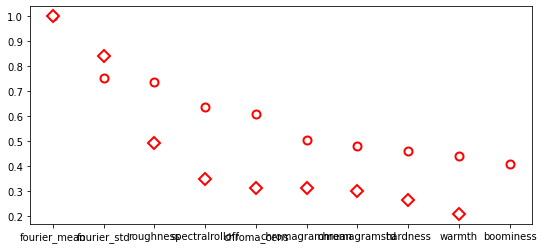

In [242]:

featImp = clf.feature_importances_
featName = clf.feature_name_

sorted_perm = r.importances_mean
sorted_perm = [x for _, x in sorted(zip(featImp,r.importances_mean),reverse=True)]
sorted_perm = sorted_perm[:len(r.importances_mean)]

sorted_labels = [x for _, x in sorted(zip(featImp,featName),reverse=True)]
sorted_columns = [x for _, x in sorted(zip(featImp,df_1.columns),reverse=True)]
sorted_columns = sorted_columns[:len(featImp)]
col='k'
hf=plt.figure(figsize=(9,4))
hf.clf()
ax=hf.add_subplot(111)
#     ax.plot(sorted_labels,sorted(clf.feature_importance(),reverse=True)/max(clf.feature_importance()), 
#             linestyle = 'none',color = col, markersize=10, marker = 'o', markerfacecolor = 'white', markeredgecolor = col, markeredgewidth=2)

for i, col in enumerate(sorted_columns):
    if ((col in columns_new_data) or (col in columns_new_data2)) or ((col=='allEarly') or (col=='allLate')) or (col=='synco'):
        col = 'g'
        ax.plot(sorted_labels[i],sorted(featImp,reverse=True)[i]/max(featImp), 
            linestyle = 'none',color = col, markersize=8, marker = 'o', markerfacecolor = 'white', markeredgecolor = col, markeredgewidth=2)
        ax.plot(sorted_labels[i],sorted(sorted_perm,reverse=True)[i]/max(sorted_perm), 
            linestyle = 'none',color = col, markersize=8, marker = 'D', markerfacecolor = 'white', markeredgecolor = col, markeredgewidth=2)
    else:
        col = 'r'
        ax.plot(sorted_labels[i],sorted(featImp,reverse=True)[i]/max(featImp), 
            linestyle = 'none',color = col, markersize=8, marker = 'o', markerfacecolor = 'white', markeredgecolor = col, markeredgewidth=2)
        ax.plot(sorted_labels[i],sorted(sorted_perm,reverse=True)[i]/max(sorted_perm), 
            linestyle = 'none',color = col, markersize=8, marker = 'D', markerfacecolor = 'white', markeredgecolor = col, markeredgewidth=2)
        
ax.set_xticks(np.arange(0,len(featImp),1))
ax.set_xticklabels(sorted_columns,rotation=70)
plt.ylim([-0.1,1.1])
plt.grid()
ax.set_ylabel('Normalised Feature importance')
ax.legend(['Split imp. rythmic','permutation imp. rythmic','Split imp. librosa+timbre','permutation imp. librosa+timbre'])

plt.tight_layout()

moreThan10pct = np.array(sorted_columns)[sorted(featImp,reverse=True) >=0.1*np.ones_like(featImp)]

# plt.savefig('plotsAfterGridsearch/PermImp_and_SplitImportance.png')

# [i for i, col in enumerate(sorted_columns) if col in columns_new_data]

In [103]:
sorted_columns[:7]
moreThan10pct

array(['fourier_mean', 'overlap0', 'chroma_cens', 'roughness',
       'spectralrolloff', 'fourier_std', 'chromagrammean', 'hardness',
       'boominess', 'onBeatHarmonic', 'overlap6', 'overlap5', 'warmth',
       'sharpness', 'chromagramstd', 'onBeatPercussive', 'overlap6Late',
       'overlap2Early', 'onBeat', 'brightness', 'overlap3Late',
       'tempoHarmonic', 'overlap5Early', 'overlap4Late', 'depth',
       'overlap4', 'overlap5Late', 'tempo', 'overlap2', 'overlap3Early',
       'tempoPercussive', 'overlap2Late', 'overlap1Early',
       'overlap4Early', 'reverb', 'overlap1', 'overlap6Early',
       'zerocrossing', 'synco', 'overlap3', 'overlap1Late'], dtype='<U16')

array([[0.41666667, 0.04166667, 0.        , 0.        , 0.08333333,
        0.04166667, 0.04166667, 0.08333333, 0.16666667, 0.125     ],
       [0.09090909, 0.54545455, 0.09090909, 0.09090909, 0.        ,
        0.        , 0.        , 0.18181818, 0.        , 0.        ],
       [0.        , 0.19354839, 0.38709677, 0.        , 0.06451613,
        0.03225806, 0.06451613, 0.12903226, 0.06451613, 0.06451613],
       [0.        , 0.04      , 0.        , 0.84      , 0.        ,
        0.        , 0.08      , 0.        , 0.        , 0.04      ],
       [0.04545455, 0.        , 0.        , 0.        , 0.63636364,
        0.09090909, 0.04545455, 0.        , 0.18181818, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.04      ,
        0.76      , 0.04      , 0.04      , 0.04      , 0.08      ],
       [0.        , 0.07692308, 0.        , 0.        , 0.        ,
        0.15384615, 0.61538462, 0.07692308, 0.        , 0.07692308],
       [0.        , 0.14285714, 0.       

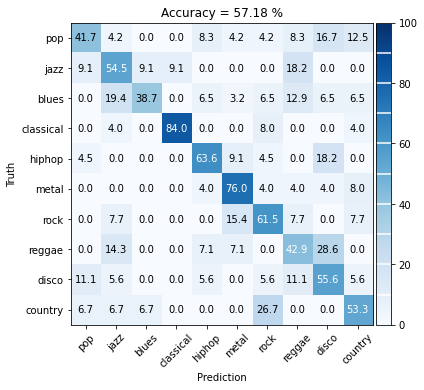

In [252]:
# score=precision_score(y_pred_lgb_probs_highest,y_val,average=None).mean()
# cmat = confusion_matrix(y_test,y_pred_m )

from mpl_toolkits.axes_grid1 import make_axes_locatable

cmat = confusion_matrix(y_test,y_pred_1,normalize='true' )
plt.figure(figsize=(6,6))
im = plt.imshow(cmat*100, cmap='Blues', vmin = 0, vmax=100)

texts = annotate_heatmap(im, valfmt="{x:.1f}")



cbticks=[10,20,30,40,50,60,70,80,90,100]

ax=plt.gca()
ax.set_xticks(np.array(chosen_genres))
ax.set_xticklabels([folders[genre_index] for genre_index in chosen_genres], rotation=45)

ax.set_yticks(np.array(chosen_genres))
ax.set_yticklabels([folders[genre_index] for genre_index in chosen_genres])
# cb=plt.colorbar(ticks=cbticks)
plt.title('Accuracy = {:.2f} %'.format(100*score))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

ax.set_xlabel('Prediction')
ax.set_ylabel('Truth')

cb=plt.colorbar(im, cax=cax)
cb.ax.plot([0,100],[cbticks, cbticks],'w')

plt.tight_layout()

# plt.savefig('plotsAfterGridsearch/top15CMAT_rythmicVars.pdf')
# plt.savefig('plotsAfterGridsearch/CMAT_AllVars.png')



plt.savefig('plotsAfterGridsearch/CMAT_LibRosaVars.png')
len(y_pred_1)
cmat

In [119]:
#### calculate shap values
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_1)
shap_obj = explainer(X_1)

LightGBMError: The number of features in data (12) is not the same as it was in training data (9).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.

10

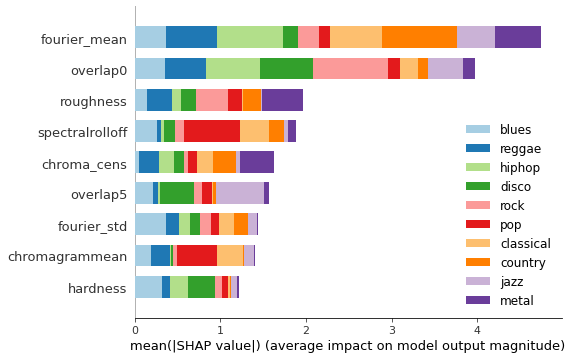

In [87]:
# evaluate shap values
# plt.grid()
# shap.summary_plot(shap_values, X_1, feature_names=df_1.columns, class_names=[folders[genre_index] for genre_index in chosen_genres],
#                  color=plt.get_cmap("Paired"),show=False)

shap.summary_plot(shap_values, X_1, feature_names=df_1.columns, class_names=[folders[genre_index] for genre_index in chosen_genres],
                 color=plt.get_cmap("Paired"),show=False)
# X_1.iloc[:,0])
# shap.plots.(shap_obj)
f=plt.gcf()
plt.tight_layout()
# plt.show()

top10SHAP = ['fourier_mean', 'overlap0','roughness','spectralrolloff','chroma_cens','chromagrammean','fourier_std','overlap5','hardness','boominess']
len(top10SHAP)
# plt.savefig('plotsAfterGridsearch/SHAP_values_AllVars.png')

In [ ]:
sorted_perm

In [139]:
distributions['learning_rate'].interval(alpha=0.7)

(-0.8374810705022251, 0.8971199848858811)

In [144]:
np.geomspace(1e-5,0.2,15)

array([1.00000000e-05, 2.02869346e-05, 4.11559714e-05, 8.34928498e-05,
       1.69381398e-04, 3.43622934e-04, 6.97105597e-04, 1.41421356e-03,
       2.86900580e-03, 5.82033329e-03, 1.18076721e-02, 2.39541470e-02,
       4.85956213e-02, 9.85856189e-02, 2.00000000e-01])

In [43]:
sorted(sorted_perm,reverse=True)[i]

'zerocrossing'